In [1]:
# BATCH:256
# batch_size:256
# data_path:"/data2"
# decay:0.7834769413661389
# EPOCH:20
# hard_reset:true
# IMAGE_SIZE:32
# learning_rate:0.007176761798504128
# pre_spike_weight:5.165214142219577
# rate_coding:true
# TIME_STEP:9
# time_step:9
# v_decay:0.7834769413661389
# v_reset:0
# v_threshold:1
# which_data:"CIFAR10"


# BATCH:256
# batch_size:256
# data_path:"/data2"
# decay:0.38993471232202725
# EPOCH:20
# hard_reset:true
# IMAGE_SIZE:28
# learning_rate:0.06285718352377828
# pre_spike_weight:6.21970124592063
# rate_coding:true
# TIME_STEP:16
# time_step:16
# v_decay:0.38993471232202725
# v_reset:0
# v_threshold:1
# which_data:"MNIST"

# BATCH:64
# batch_size:64
# data_path:"/data2"
# decay:0.9266077968579136
# EPOCH:20
# hard_reset:true
# IMAGE_SIZE:28
# learning_rate:0.07732456724854177
# pre_spike_weight:1.5377416716615555
# rate_coding:true
# TIME_STEP:7
# time_step:7
# v_decay:0.9266077968579136
# v_reset:0
# v_threshold:1
# which_data:"FASHION_MNIST"

In [2]:
# Copyright (c) 2024 Byeonghyeon Kim 
# github site: https://github.com/bhkim003/ByeonghyeonKim
# email: bhkim003@snu.ac.kr
 
# Permission is hereby granted, free of charge, to any person obtaining a copy of
# this software and associated documentation files (the "Software"), to deal in
# the Software without restriction, including without limitation the rights to
# use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
# the Software, and to permit persons to whom the Software is furnished to do so,
# subject to the following conditions:
 
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
 
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
# FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
# COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
# IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.


In [3]:
import sys
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt


from snntorch import spikegen

 
import wandb

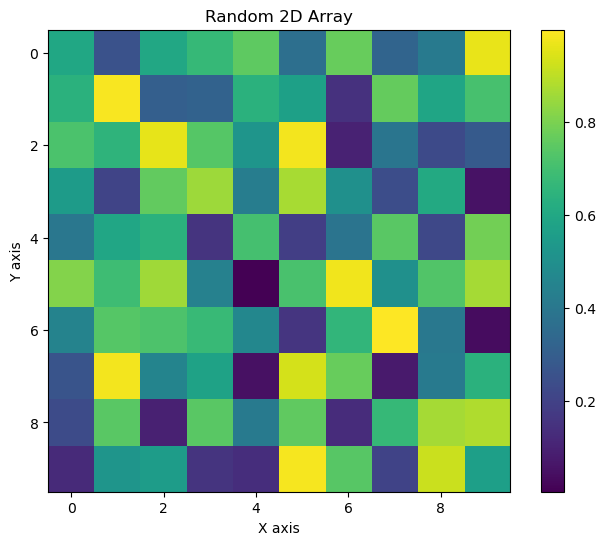

In [4]:
# my module import
from modules import *

In [5]:
    
class RESERVOIR(nn.Module):
    def __init__ (self, TIME_STEP=8, in_spike_size=28, in_channel=1, receptive_size=3, v_init=0, v_decay=0.6, v_threshold=1, v_reset=0, hard_reset=True, pre_spike_weight=1,
                  FC_RESERVOIR=False):
        super(RESERVOIR, self).__init__()
        self.TIME_STEP = TIME_STEP
        self.in_spike_size = in_spike_size
        self.in_channel = in_channel
        self.receptive_size = receptive_size #3
        self.v_init = v_init
        self.v_decay = v_decay
        self.v_threshold = v_threshold
        self.v_reset = v_reset
        self.hard_reset = hard_reset
        self.pre_spike_weight = pre_spike_weight
        self.FC_RESERVOIR = FC_RESERVOIR

        self.out_channel = 1

        # 파라미터 
        if self.FC_RESERVOIR == True:
            self.reservoir = nn.Linear(in_features=self.in_channel*self.in_spike_size*self.in_spike_size, out_features=self.in_channel*self.in_spike_size*self.in_spike_size, bias=True)
        else:
            self.reservoir = nn.Conv2d(in_channels=self.in_channel, out_channels=self.in_channel, 
                                            kernel_size=self.receptive_size, 
                                            stride=1, padding=1, groups=self.in_channel)

        # kaiming 초기화
        nn.init.kaiming_normal_(self.reservoir.weight, mode='fan_out', nonlinearity='relu')
        nn.init.constant_(self.reservoir.bias, 0)

        # membrane potential 초기화
        self.v = torch.full((self.in_channel, self.in_spike_size, self.in_spike_size), fill_value=self.v_init, requires_grad=False)

        
    def forward(self, pre_spike):    
        # pre_spike [TIME_STEP, batch_size, in_channel, in_spike_size, in_spike_size]

        v = torch.full_like(pre_spike[0], fill_value=self.v_init, requires_grad=False)
        post_spike = torch.zeros_like(pre_spike[0], requires_grad=False)
        # v [batch_size, in_channel, in_spike_size, in_spike_size]
        # recurrent [batch_size, in_channel, in_spike_size, in_spike_size]

        # timestep 안 맞으면 종료
        assert pre_spike.size(0) == self.TIME_STEP, f"Time step mismatch: {pre_spike.size(0)} vs {self.TIME_STEP}"

        output = []
        for t in range (self.TIME_STEP):
            # depthwise conv reservoir: pre_spike[t] [batch_size, in_channel, in_spike_size, in_spike_size]
            # fc conv reservoir: pre_spike[t] [batch_size, in_channel*in_spike_size*in_spike_size]
            input_current = self.pre_spike_weight * pre_spike[t]
                
            recurrent_current = self.reservoir(post_spike)
            current = input_current + recurrent_current
            # current [batch_size, in_channel, in_spike_size, in_spike_size] # kernel size 3이니까 사이즈 유지
            
            # decay and itegrate
            v = v*self.v_decay + current

            # post spike
            post_spike = (v >= self.v_threshold).float()

            output.append(post_spike)
            
            #reset
            if self.hard_reset: # hard reset
                v = (1 - post_spike)*v + post_spike*self.v_reset 
            else: # soft reset
                v = v - post_spike*self.v_threshold

        output = torch.stack(output, dim=0)
        return output

In [6]:
class RESERVOIR_NET(nn.Module):
    def __init__(self, TIME_STEP=8, CLASS_NUM=10, in_spike_size=28, in_channel=1, receptive_size=3, v_init=0, v_decay=0.6, v_threshold=1, v_reset=0, hard_reset=True, pre_spike_weight=1,
                 no_reservoir = False, FC_RESERVOIR=False):
        super(RESERVOIR_NET, self).__init__()
        self.TIME_STEP = TIME_STEP
        self.no_reservoir = no_reservoir
        self.FC_RESERVOIR = FC_RESERVOIR

        if self.no_reservoir == False:
            self.reservoir = RESERVOIR(TIME_STEP = self.TIME_STEP, in_spike_size=in_spike_size, in_channel=in_channel, receptive_size=receptive_size, v_init=v_init, v_decay=v_decay, v_threshold=v_threshold, v_reset=v_reset, hard_reset=hard_reset, pre_spike_weight=pre_spike_weight,
                                       FC_RESERVOIR=FC_RESERVOIR)
        
        self.classifier = nn.Linear(in_features=in_channel*in_spike_size*in_spike_size, out_features=CLASS_NUM)

    def forward(self, x):
        assert self.TIME_STEP == x.size(1), f"Time step mismatch: {x.size(1)} vs {self.TIME_STEP}"

        # x size [batch_size, TIME_STEP, in_channel, in_spike_size, in_spike_size]
        x = x.permute(1,0,2,3,4)
        # x size [TIME_STEP, batch_size, in_channel, in_spike_size, in_spike_size]

        if (self.FC_RESERVOIR == True):
            x = x.reshape(x.size(0), x.size(1), -1)

        if self.no_reservoir == False:
            with torch.no_grad():
                x = self.reservoir(x) # reservoir weight는 학습 안함

        T, B, *spatial_dims = x.shape

        x = x.reshape(T * B, -1) # time,batch 축은 합쳐서 FC에 삽입

        x = self.classifier(x)

        x = x.view(T , B, -1).contiguous() 
        
        x = x.mean(dim=0)
        return x

In [7]:
def data_loader(which_data, data_path, rate_coding, BATCH, IMAGE_SIZE, TIME, dvs_duration, dvs_clipping):
    if which_data == 'MNIST':
        if rate_coding :
            transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0,), (1,))])
        else : 
            transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,),(0.5))])

        trainset = torchvision.datasets.MNIST(root=data_path,
                                            train=True,
                                            download=True,
                                            transform=transform)


        testset = torchvision.datasets.MNIST(root=data_path,
                                            train=False,
                                            download=True,
                                            transform=transform)

        train_loader = DataLoader(trainset,
                                batch_size =BATCH,
                                shuffle = True,
                                num_workers =2)
        test_loader = DataLoader(testset,
                                batch_size =BATCH,
                                shuffle = False,
                                num_workers =2)
        synapse_conv_in_channels = 1
        CLASS_NUM = 10


    

    elif (which_data == 'CIFAR10'):

        if rate_coding :
            # transform_train = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            #                                     transforms.RandomHorizontalFlip(),
            #                                     transforms.ToTensor()])

            # transform_test = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            #                                     transforms.ToTensor()])
            
            transform_train = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                                transforms.RandomHorizontalFlip(),
                                                transforms.ToTensor()])
                                            # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

            transform_test = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                                transforms.ToTensor()])
        
        else :
            # transform_train = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            #                                     transforms.RandomHorizontalFlip(),
            #                                     transforms.ToTensor(),
            #                                     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])
            #                                 # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

            # transform_test = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            #                                     transforms.ToTensor(),
            #                                     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),])
            #                                 # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            
            # assert IMAGE_SIZE == 32, 'OTTT랑 맞짱뜰 때는 32로 ㄱ'
            transform_train = transforms.Compose([
                transforms.RandomCrop(IMAGE_SIZE, padding=4),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465),
                                    (0.2023, 0.1994, 0.2010)),
            ])
            transform_test = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465),
                                    (0.2023, 0.1994, 0.2010)),
            ])

        trainset = torchvision.datasets.CIFAR10(root=data_path,
                                            train=True,
                                            download=True,
                                            transform=transform_train)


        testset = torchvision.datasets.CIFAR10(root=data_path,
                                            train=False,
                                            download=True,
                                            transform=transform_test)
        
        
        train_loader = DataLoader(trainset,
                                batch_size =BATCH,
                                shuffle = True,
                                num_workers =2)
        test_loader = DataLoader(testset,
                                batch_size =BATCH,
                                shuffle = False,
                                num_workers =2)
        
        synapse_conv_in_channels = 3
        CLASS_NUM = 10
        '''
        classes = ('plane', 'car', 'bird', 'cat', 'deer',
                'dog', 'frog', 'horse', 'ship', 'truck') 
        '''


    elif (which_data == 'FASHION_MNIST'):

        if rate_coding :
            transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                    transforms.ToTensor()])
        else : 
            transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,),(0.5))])

        trainset = torchvision.datasets.FashionMNIST(root=data_path,
                                            train=True,
                                            download=True,
                                            transform=transform)


        testset = torchvision.datasets.FashionMNIST(root=data_path,
                                            train=False,
                                            download=True,
                                            transform=transform)

        train_loader = DataLoader(trainset,
                                batch_size =BATCH,
                                shuffle = True,
                                num_workers =2)
        test_loader = DataLoader(testset,
                                batch_size =BATCH,
                                shuffle = False,
                                num_workers =2)
        synapse_conv_in_channels = 1
        CLASS_NUM = 10
    elif (which_data == 'DVS_GESTURE'):
        data_dir = data_path + '/gesture'
        transform = None

        # # spikingjelly.datasets.dvs128_gesture.DVS128Gesture(root: str, train: bool, use_frame=True, frames_num=10, split_by='number', normalization='max')
       
        #https://spikingjelly.readthedocs.io/zh-cn/latest/activation_based_en/neuromorphic_datasets.html
        # 10ms마다 1개의 timestep하고 싶으면 위의 주소 참고. 근데 timestep이 각각 좀 다를 거임.

        if dvs_duration > 0:
            resize_shape = (IMAGE_SIZE, IMAGE_SIZE)
            train_data = CustomDVS128Gesture(
                data_dir, train=True, data_type='frame',  split_by='time',  duration=dvs_duration, resize_shape=resize_shape, dvs_clipping=dvs_clipping, dvs_duration_copy=dvs_duration, TIME=TIME)
            test_data = CustomDVS128Gesture(
                data_dir, train=False, data_type='frame',  split_by='time',  duration=dvs_duration, resize_shape=resize_shape, dvs_clipping=dvs_clipping, dvs_duration_copy=dvs_duration, TIME=TIME)
        else:
            train_data = CustomDVS128Gesture(
                data_dir, train=True, data_type='frame', split_by='number', frames_number=TIME, resize_shape=resize_shape, dvs_clipping=dvs_clipping, dvs_duration_copy=dvs_duration, TIME=TIME)
            test_data = CustomDVS128Gesture(data_dir, train=False,
                                            data_type='frame', split_by='number', frames_number=TIME, resize_shape=resize_shape, dvs_clipping=dvs_clipping, dvs_duration_copy=dvs_duration, TIME=TIME)
        
        ## 11번째 클래스 배제 ########################################################################
        exclude_class = 10
        if dvs_duration > 0:
            train_file_name = f'modules/dvs_gesture_class_index/train_indices_dvsgesture_duration_{dvs_duration}'
            test_file_name = f'modules/dvs_gesture_class_index/test_indices_dvsgesture_duration_{dvs_duration}'
            if (os.path.isfile(train_file_name) and os.path.isfile(test_file_name)):
                print('\ndvsgestrue 10 class indices exist. we want to exclude the 11th class\n')
                with open(train_file_name, 'rb') as f:
                    train_indices = pickle.load(f)
                with open(test_file_name, 'rb') as f:
                    test_indices = pickle.load(f)
            else:
                print('\ndvsgestrue 10 class indices doesn\'t exist. we want to exclude the 11th class\n')
                train_indices = [i for i, (_, target) in enumerate(train_data) if target != exclude_class]
                test_indices = [i for i, (_, target) in enumerate(test_data) if target != exclude_class]
                with open(train_file_name, 'wb') as f:
                    pickle.dump(train_indices, f)
                with open(test_file_name, 'wb') as f:
                    pickle.dump(test_indices, f)
        else:
            train_indices = [i for i, (_, target) in enumerate(train_data) if target != exclude_class]
            test_indices = [i for i, (_, target) in enumerate(test_data) if target != exclude_class]
        ################################################################################################

        # SubsetRandomSampler 생성
        train_sampler = SubsetRandomSampler(train_indices)
        test_sampler = SequentialSampler(test_indices)

        # ([B, T, 2, 128, 128]) 
        train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH, num_workers=2, sampler=train_sampler, collate_fn=pad_sequence_collate)
        test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=BATCH, num_workers=2, sampler=test_sampler, collate_fn=pad_sequence_collate)
        synapse_conv_in_channels = 2
        CLASS_NUM = 10
        # mapping = { 0 :'Hand Clapping'  1 :'Right Hand Wave'2 :'Left Hand Wave' 3 :'Right Arm CW'   4 :'Right Arm CCW'  5 :'Left Arm CW'    6 :'Left Arm CCW'   7 :'Arm Roll'       8 :'Air Drums'      9 :'Air Guitar'     10:'Other'}

    else:
        assert False, 'wrong dataset name'


    
    return train_loader, test_loader, synapse_conv_in_channels, CLASS_NUM

In [8]:
def train(model, train_loader, criterion, optimizer, device, rate_coding, TIME_STEP, which_data):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    iterator = enumerate(train_loader, 0)
    for i, data in iterator:
    # for i, (inputs, labels) in enumerate(train_loader):
        if len(data) == 2:
            inputs, labels = data
            # 처리 로직 작성
        elif len(data) == 3:
            inputs, labels, x_len = data

        inputs, labels = inputs.to(device), labels.to(device)

        # if rate_coding == True:
        #     inputs = spikegen.rate(inputs, num_steps=TIME_STEP)
        # else:
        #     inputs = inputs.repeat(TIME_STEP, 1, 1, 1, 1)
        

        ###########################################################################################################################        
        if (which_data == 'n_tidigits'):
            inputs = inputs.permute(0, 1, 3, 2, 4)
            labels = labels[:, 0, :]
            labels = torch.argmax(labels, dim=1)
        elif (which_data == 'heidelberg'):
            inputs = inputs.view(5, 1000, 1, 700, 1)
            print("\n\n\n경고!!!! heidelberg 이거 타임스텝이랑 채널 잘 바꿔줘라!!!\n\n\n\n")
        # print('inputs',inputs.size(),'\nlabels',labels.size())
        # print(labels)
            
        if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
            inputs = inputs.permute(1, 0, 2, 3, 4)
        elif rate_coding == True :
            inputs = spikegen.rate(inputs, num_steps=TIME_STEP)
        else :
            inputs = inputs.repeat(TIME_STEP, 1, 1, 1, 1)
        # inputs: [Time, Batch, Channel, Height, Width]  
        ####################################################################################################################### 

        
        
        
        
        inputs = inputs.permute(1, 0, 2, 3, 4)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        iter_correct = (predicted == labels).sum().item()
        correct += iter_correct
        # if i % 100 == 99:
        # print(f"[{i+1}] loss: {running_loss / 100:.3f}")
        # running_loss = 0.0
        iter_accuracy = 100 * iter_correct / labels.size(0)
        wandb.log({"iter_accuracy": iter_accuracy})
    tr_accuracy = 100 * correct / total         
    wandb.log({"tr_accuracy": tr_accuracy})
    print(f"Train Accuracy: {tr_accuracy:.2f}%")
    
def test(model, test_loader, criterion, device, rate_coding, TIME_STEP, which_data):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    iterator = enumerate(test_loader, 0)
    with torch.no_grad():
        for i, data in iterator:
        # for inputs, labels in test_loader:
            if len(data) == 2:
                inputs, labels = data
                # 처리 로직 작성
            elif len(data) == 3:
                inputs, labels, x_len = data
                
            inputs, labels = inputs.to(device), labels.to(device)

            # if rate_coding == True:
            #     inputs = spikegen.rate(inputs, num_steps=TIME_STEP)
            # else:
            #     inputs = inputs.repeat(TIME_STEP, 1, 1, 1, 1)

        

            ###########################################################################################################################        
            if (which_data == 'n_tidigits'):
                inputs = inputs.permute(0, 1, 3, 2, 4)
                labels = labels[:, 0, :]
                labels = torch.argmax(labels, dim=1)
            elif (which_data == 'heidelberg'):
                inputs = inputs.view(5, 1000, 1, 700, 1)
                print("\n\n\n경고!!!! heidelberg 이거 타임스텝이랑 채널 잘 바꿔줘라!!!\n\n\n\n")
            # print('inputs',inputs.size(),'\nlabels',labels.size())
            # print(labels)
                
            if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
                inputs = inputs.permute(1, 0, 2, 3, 4)
            elif rate_coding == True :
                inputs = spikegen.rate(inputs, num_steps=TIME_STEP)
            else :
                inputs = inputs.repeat(TIME_STEP, 1, 1, 1, 1)
            # inputs: [Time, Batch, Channel, Height, Width]  
            ####################################################################################################################### 

        


            inputs = inputs.permute(1, 0, 2, 3, 4)
        
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_accuracy = 100 * correct / total
    wandb.log({"val_accuracy": val_accuracy})
    print(f"Test loss: {test_loss / len(test_loader):.3f}, Val Accuracy: {val_accuracy:.2f}%")


In [9]:
def main(data_path='/data2', which_data='MNIST', gpu = '3',learning_rate = 0.0001, BATCH=5, IMAGE_SIZE=28, TIME_STEP=8, EPOCH=10, rate_coding=True, v_decay= 0.6,
v_threshold=1, v_reset=0, hard_reset=True, pre_spike_weight=1, dvs_duration=1000000, dvs_clipping=True, no_reservoir = False, FC_RESERVOIR=False):
    os.environ["CUDA_VISIBLE_DEVICES"]= gpu
    # run = wandb.init(project=f'reservoir')

    hyperparameters = locals()

    wandb.config.update(hyperparameters)
    wandb.run.name = f'{which_data}_sweeprun_epoch{EPOCH}'
    wandb.run.log_code(".", include_fn=lambda path: path.endswith(".py") or path.endswith(".ipynb"))

    train_loader, test_loader, in_channel, CLASS_NUM = data_loader(
        which_data=which_data, data_path=data_path, rate_coding=rate_coding, BATCH=BATCH, IMAGE_SIZE=IMAGE_SIZE, TIME=TIME_STEP, dvs_duration=dvs_duration, dvs_clipping=dvs_clipping)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    net = RESERVOIR_NET(TIME_STEP=TIME_STEP, CLASS_NUM=CLASS_NUM, in_spike_size=IMAGE_SIZE, in_channel=in_channel, receptive_size=3, v_init=0, v_decay=v_decay, v_threshold=v_threshold, v_reset=v_reset, hard_reset=hard_reset, pre_spike_weight=pre_spike_weight, 
                            no_reservoir = no_reservoir, FC_RESERVOIR=FC_RESERVOIR)
    net = net.to(device)
    wandb.watch(net, log="all", log_freq = 1) #gradient, parameter logging해줌

    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0)

    print(net)

    for epoch in range(EPOCH):
        print(f"Epoch {epoch+1}")
        train(net, train_loader, criterion, optimizer, device, rate_coding, TIME_STEP, which_data)
        test(net, test_loader, criterion, device, rate_coding, TIME_STEP, which_data)
        wandb.log({"epoch": epoch})
        # torch.save(net.state_dict(), 'net_save/reservoir_net.pth')
        # artifact = wandb.Artifact('model', type='model')
        # artifact.add_file('net_save/reservoir_net.pth')
        # run.log_artifact(artifact)


In [10]:
# # sweep 하기 싫을 때
# wandb.init(project=f'reservoir')
# main(data_path='/data2', which_data='CIFAR10', gpu = '3', learning_rate = 0.0072, BATCH=256, IMAGE_SIZE=32, TIME_STEP=9, EPOCH=50, rate_coding=True, v_decay= 0.78,
# v_threshold=1, v_reset=0, hard_reset=True, pre_spike_weight=5.0, dvs_duration=1000000, dvs_clipping=True, no_reservoir = False, FC_RESERVOIR=False)

In [11]:
# sweep하고싶을 때
def sweep_cover(data_path='/data2', which_data='CIFAR10', gpu = '7', learning_rate = 0.0001, BATCH=5, IMAGE_SIZE=28, TIME_STEP=8, EPOCH=3, rate_coding=True, v_decay= 0.6,
v_threshold=1, v_reset=0, hard_reset=True, pre_spike_weight=1, dvs_duration=1000000, dvs_clipping=True, no_reservoir = False, FC_RESERVOIR=False):
    
    wandb.init(save_code = True)

    learning_rate  =  wandb.config.learning_rate
    BATCH  =  wandb.config.batch_size
    TIME_STEP  =  wandb.config.time_step
    v_decay  =  wandb.config.decay
    pre_spike_weight  =  wandb.config.pre_spike_weight
    which_data  =  wandb.config.which_data
    data_path  =  wandb.config.data_path
    rate_coding  =  wandb.config.rate_coding
    EPOCH  =  wandb.config.EPOCH
    IMAGE_SIZE  =  wandb.config.IMAGE_SIZE
    dvs_duration  =  wandb.config.dvs_duration
    dvs_clipping  =  wandb.config.dvs_clipping
    no_reservoir  =  wandb.config.no_reservoir
    FC_RESERVOIR  =  wandb.config.FC_RESERVOIR
    main(data_path=data_path, which_data=which_data, gpu = gpu, learning_rate = learning_rate, BATCH=BATCH, IMAGE_SIZE=IMAGE_SIZE, TIME_STEP=TIME_STEP, EPOCH=EPOCH, rate_coding=rate_coding, v_decay= v_decay,
v_threshold=v_threshold, v_reset=v_reset, hard_reset=hard_reset, pre_spike_weight=pre_spike_weight, dvs_duration=dvs_duration, dvs_clipping=dvs_clipping, no_reservoir = no_reservoir, FC_RESERVOIR=FC_RESERVOIR)



which_data_hyper = 'MNIST' # 'MNIST', 'CIFAR10' ', 'FASHION_MNIST', 'DVS_GESTURE'
data_path_hyper = '/data2'

sweep_configuration = {
    'method': 'bayes',
    'name': f'{which_data_hyper} fc_reservoir',
    'metric': {'goal': 'maximize', 'name': 'val_accuracy'},
    'parameters': 
    {
        "learning_rate": {"values": [0.09]},
        "batch_size": {"values": [128, 256]},
        "time_step": {"values": [4,5,6,7,8]},
        "decay": {"values": [0.7]},
        "pre_spike_weight": {"min": 0.5, "max": 10.0},
        "which_data": {"values": [which_data_hyper]},
        "data_path": {"values": [data_path_hyper]},
        "rate_coding": {"values": [True, False]},
        "EPOCH": {"values": [3]},
        "IMAGE_SIZE": {"values": [28]},
        "dvs_duration": {"values": [1000000]},
        "dvs_clipping": {"values": [True]},
        "no_reservoir": {"values": [True, False]},
        "FC_RESERVOIR": {"values": [True]},
     }
}

sweep_id = wandb.sweep(sweep=sweep_configuration, project=f'reservoir')
wandb.agent(sweep_id, function=sweep_cover, count=10000)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: vz1kbys1
Sweep URL: https://wandb.ai/bhkim003-seoul-national-university/reservoir/sweeps/vz1kbys1


wandb: Agent Starting Run: hvxizywt with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.338504673816841
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: bhkim003 (bhkim003-seoul-national-university). Use `wandb login --relogin` to force relogin


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.57%
Test loss: 0.311, Val Accuracy: 90.91%
Epoch 2
Train Accuracy: 91.00%
Test loss: 0.297, Val Accuracy: 91.26%
Epoch 3
Train Accuracy: 91.42%
Test loss: 0.295, Val Accuracy: 91.16%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xzfasszx with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.247169290788632
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.66%
Test loss: 0.280, Val Accuracy: 92.22%
Epoch 2
Train Accuracy: 91.75%
Test loss: 0.278, Val Accuracy: 91.79%
Epoch 3
Train Accuracy: 92.17%
Test loss: 0.262, Val Accuracy: 92.64%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vtnsas5s with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.0712521703187572
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.34%
Test loss: 0.336, Val Accuracy: 90.42%
Epoch 2
Train Accuracy: 90.56%
Test loss: 0.318, Val Accuracy: 90.58%
Epoch 3
Train Accuracy: 91.13%
Test loss: 0.312, Val Accuracy: 91.07%


wandb: Agent Starting Run: tp03nx9d with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.541373078339674
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.38%
Test loss: 0.506, Val Accuracy: 89.56%
Epoch 2
Train Accuracy: 89.66%
Test loss: 0.407, Val Accuracy: 89.79%
Epoch 3
Train Accuracy: 89.57%
Test loss: 0.330, Val Accuracy: 91.22%


wandb: Agent Starting Run: e8bfwwvm with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.256772247021593
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.57%
Test loss: 0.294, Val Accuracy: 91.39%
Epoch 2
Train Accuracy: 91.43%
Test loss: 0.272, Val Accuracy: 92.03%
Epoch 3
Train Accuracy: 91.90%
Test loss: 0.265, Val Accuracy: 92.35%


wandb: Agent Starting Run: nte5vday with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.44406652312513
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.65%
Test loss: 0.306, Val Accuracy: 91.21%
Epoch 2
Train Accuracy: 91.12%
Test loss: 0.302, Val Accuracy: 91.17%
Epoch 3
Train Accuracy: 91.34%
Test loss: 0.325, Val Accuracy: 90.57%


wandb: Agent Starting Run: mwi4i16f with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.0368247894987683
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.59%
Test loss: 0.313, Val Accuracy: 91.04%
Epoch 2
Train Accuracy: 91.08%
Test loss: 0.300, Val Accuracy: 91.59%
Epoch 3
Train Accuracy: 91.42%
Test loss: 0.318, Val Accuracy: 91.14%


wandb: Agent Starting Run: u20c2bfp with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.204071220850962
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.20%
Test loss: 1.085, Val Accuracy: 82.80%
Epoch 2
Train Accuracy: 88.04%
Test loss: 0.672, Val Accuracy: 87.83%
Epoch 3
Train Accuracy: 87.99%
Test loss: 0.510, Val Accuracy: 90.19%


wandb: Agent Starting Run: goyc7kcd with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.761201248416054
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 85.01%
Test loss: 0.687, Val Accuracy: 85.34%
Epoch 2
Train Accuracy: 87.74%
Test loss: 0.538, Val Accuracy: 87.74%
Epoch 3
Train Accuracy: 87.92%
Test loss: 0.560, Val Accuracy: 89.03%


wandb: Agent Starting Run: w1miox4c with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.0830926025410463
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.73%
Test loss: 0.309, Val Accuracy: 91.22%
Epoch 2
Train Accuracy: 91.17%
Test loss: 0.293, Val Accuracy: 91.45%
Epoch 3
Train Accuracy: 91.50%
Test loss: 0.288, Val Accuracy: 91.94%


wandb: Agent Starting Run: 7syxsb9e with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.487697369164511
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.81%
Test loss: 0.281, Val Accuracy: 91.67%
Epoch 2
Train Accuracy: 91.80%
Test loss: 0.266, Val Accuracy: 92.17%
Epoch 3
Train Accuracy: 92.25%
Test loss: 0.255, Val Accuracy: 92.54%


wandb: Agent Starting Run: hfolayo7 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.99926933326867
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.29%
Test loss: 0.484, Val Accuracy: 90.96%
Epoch 2
Train Accuracy: 88.29%
Test loss: 0.453, Val Accuracy: 90.87%
Epoch 3
Train Accuracy: 87.99%
Test loss: 0.642, Val Accuracy: 86.91%


wandb: Agent Starting Run: wad3y1gd with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.551443712642879
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.06%
Test loss: 0.426, Val Accuracy: 90.72%
Epoch 2
Train Accuracy: 89.33%
Test loss: 0.343, Val Accuracy: 91.68%
Epoch 3
Train Accuracy: 89.83%
Test loss: 0.365, Val Accuracy: 91.01%


wandb: Agent Starting Run: 6p15gtnl with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.144165374135003
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.67%
Test loss: 0.297, Val Accuracy: 91.36%
Epoch 2
Train Accuracy: 91.25%
Test loss: 0.274, Val Accuracy: 92.10%
Epoch 3
Train Accuracy: 91.93%
Test loss: 0.276, Val Accuracy: 92.08%


wandb: Agent Starting Run: v1dr1i1z with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.225680249080546
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.03%
Test loss: 0.814, Val Accuracy: 86.82%
Epoch 2
Train Accuracy: 88.55%
Test loss: 0.569, Val Accuracy: 88.54%
Epoch 3
Train Accuracy: 87.61%
Test loss: 0.526, Val Accuracy: 90.17%


wandb: Agent Starting Run: dcteflxu with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.287889811709769
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.86%
Test loss: 0.305, Val Accuracy: 91.48%
Epoch 2
Train Accuracy: 91.11%
Test loss: 0.289, Val Accuracy: 91.94%
Epoch 3
Train Accuracy: 91.60%
Test loss: 0.284, Val Accuracy: 92.08%


wandb: Agent Starting Run: xan6ldpp with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.073384114489963
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.82%
Test loss: 0.529, Val Accuracy: 88.24%
Epoch 2
Train Accuracy: 89.37%
Test loss: 0.403, Val Accuracy: 90.24%
Epoch 3
Train Accuracy: 90.07%
Test loss: 0.421, Val Accuracy: 88.88%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: czkg9byi with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.411821388304712
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.17%
Test loss: 0.318, Val Accuracy: 91.11%
Epoch 2
Train Accuracy: 90.71%
Test loss: 0.308, Val Accuracy: 91.15%
Epoch 3
Train Accuracy: 91.27%
Test loss: 0.299, Val Accuracy: 91.44%


wandb: Agent Starting Run: y68vl5a1 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.202599565022714
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.58%
Test loss: 0.308, Val Accuracy: 91.22%
Epoch 2
Train Accuracy: 91.00%
Test loss: 0.302, Val Accuracy: 91.25%
Epoch 3
Train Accuracy: 91.41%
Test loss: 0.297, Val Accuracy: 91.41%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: yeocietn with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.71280916873161
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.50%
Test loss: 0.303, Val Accuracy: 91.27%
Epoch 2
Train Accuracy: 91.33%
Test loss: 0.280, Val Accuracy: 91.82%
Epoch 3
Train Accuracy: 91.95%
Test loss: 0.265, Val Accuracy: 92.32%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8pbi9umf with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.359532198078723
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 82.96%
Test loss: 0.497, Val Accuracy: 90.43%
Epoch 2
Train Accuracy: 89.31%
Test loss: 0.436, Val Accuracy: 89.91%
Epoch 3
Train Accuracy: 90.02%
Test loss: 0.398, Val Accuracy: 89.90%


wandb: Agent Starting Run: vnsph6zk with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.779401033234162
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.67%
Test loss: 0.299, Val Accuracy: 91.20%
Epoch 2
Train Accuracy: 91.38%
Test loss: 0.275, Val Accuracy: 91.87%
Epoch 3
Train Accuracy: 92.01%
Test loss: 0.261, Val Accuracy: 92.37%


wandb: Agent Starting Run: vdml3e1d with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 0.5982921516620048
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.75%
Test loss: 0.306, Val Accuracy: 91.69%
Epoch 2
Train Accuracy: 91.22%
Test loss: 0.288, Val Accuracy: 91.70%
Epoch 3
Train Accuracy: 91.60%
Test loss: 0.281, Val Accuracy: 92.03%


wandb: Agent Starting Run: r7mfoito with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.766488350669915
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.75%
Test loss: 0.310, Val Accuracy: 90.78%
Epoch 2
Train Accuracy: 91.22%
Test loss: 0.292, Val Accuracy: 91.81%
Epoch 3
Train Accuracy: 91.43%
Test loss: 0.288, Val Accuracy: 91.87%


wandb: Agent Starting Run: y5ev57v1 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.229014765995429
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.64%
Test loss: 0.295, Val Accuracy: 91.26%
Epoch 2
Train Accuracy: 91.25%
Test loss: 0.280, Val Accuracy: 91.81%
Epoch 3
Train Accuracy: 91.75%
Test loss: 0.272, Val Accuracy: 92.11%


wandb: Agent Starting Run: 612eikla with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.176885223563403
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.88%
Test loss: 0.903, Val Accuracy: 83.26%
Epoch 2
Train Accuracy: 88.25%
Test loss: 0.536, Val Accuracy: 88.80%
Epoch 3
Train Accuracy: 87.84%
Test loss: 0.658, Val Accuracy: 87.83%


wandb: Agent Starting Run: 4jkdom7q with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.012868207378485
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.50%
Test loss: 0.312, Val Accuracy: 90.96%
Epoch 2
Train Accuracy: 91.00%
Test loss: 0.301, Val Accuracy: 91.12%
Epoch 3
Train Accuracy: 91.45%
Test loss: 0.293, Val Accuracy: 91.59%


wandb: Agent Starting Run: 1atsez6h with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.851420589189694
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.81%
Test loss: 0.299, Val Accuracy: 91.50%
Epoch 2
Train Accuracy: 91.30%
Test loss: 0.298, Val Accuracy: 91.67%
Epoch 3
Train Accuracy: 91.69%
Test loss: 0.288, Val Accuracy: 91.57%


wandb: Agent Starting Run: dlurl4f3 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.233605414880622
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.38%
Test loss: 0.314, Val Accuracy: 91.16%
Epoch 2
Train Accuracy: 90.91%
Test loss: 0.305, Val Accuracy: 91.34%
Epoch 3
Train Accuracy: 91.39%
Test loss: 0.297, Val Accuracy: 91.45%


wandb: Agent Starting Run: ckl9pjzd with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.9863625527941684
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.70%
Test loss: 0.286, Val Accuracy: 91.84%
Epoch 2
Train Accuracy: 91.67%
Test loss: 0.272, Val Accuracy: 91.96%
Epoch 3
Train Accuracy: 92.22%
Test loss: 0.249, Val Accuracy: 92.85%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ite0w3ar with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.158491711469267
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.33%
Test loss: 0.629, Val Accuracy: 88.64%
Epoch 2
Train Accuracy: 88.04%
Test loss: 0.808, Val Accuracy: 84.42%
Epoch 3
Train Accuracy: 88.33%
Test loss: 0.686, Val Accuracy: 87.15%


wandb: Agent Starting Run: 7gae5xsj with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.446786932729434
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.86%
Test loss: 0.286, Val Accuracy: 91.84%
Epoch 2
Train Accuracy: 91.56%
Test loss: 0.272, Val Accuracy: 92.38%
Epoch 3
Train Accuracy: 92.05%
Test loss: 0.274, Val Accuracy: 91.45%


wandb: Agent Starting Run: udqolvk0 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.996317191798902
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.78%
Test loss: 0.303, Val Accuracy: 91.36%
Epoch 2
Train Accuracy: 91.04%
Test loss: 0.286, Val Accuracy: 92.01%
Epoch 3
Train Accuracy: 91.63%
Test loss: 0.291, Val Accuracy: 91.50%


wandb: Agent Starting Run: bj4mij93 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.642515562796012
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.73%
Test loss: 0.308, Val Accuracy: 90.99%
Epoch 2
Train Accuracy: 91.10%
Test loss: 0.290, Val Accuracy: 91.57%
Epoch 3
Train Accuracy: 91.49%
Test loss: 0.281, Val Accuracy: 92.02%


wandb: Agent Starting Run: qhlck5m8 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.37367411088473
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.62%
Test loss: 0.310, Val Accuracy: 91.32%
Epoch 2
Train Accuracy: 91.20%
Test loss: 0.291, Val Accuracy: 92.01%
Epoch 3
Train Accuracy: 91.52%
Test loss: 0.284, Val Accuracy: 91.94%


wandb: Agent Starting Run: mmel74i6 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.842990809136072
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.41%
Test loss: 0.319, Val Accuracy: 91.04%
Epoch 2
Train Accuracy: 90.92%
Test loss: 0.298, Val Accuracy: 91.43%
Epoch 3
Train Accuracy: 91.35%
Test loss: 0.297, Val Accuracy: 91.37%


wandb: Agent Starting Run: 3jxiyj4g with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.0507524816747225
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.06%
Test loss: 0.669, Val Accuracy: 88.16%
Epoch 2
Train Accuracy: 88.28%
Test loss: 0.870, Val Accuracy: 84.69%
Epoch 3
Train Accuracy: 88.22%
Test loss: 0.664, Val Accuracy: 87.28%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ngiz89dm with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.001471372639745
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.68%
Test loss: 0.302, Val Accuracy: 91.19%
Epoch 2
Train Accuracy: 91.33%
Test loss: 0.286, Val Accuracy: 91.39%
Epoch 3
Train Accuracy: 91.86%
Test loss: 0.266, Val Accuracy: 92.08%


wandb: Agent Starting Run: xtw8mjjn with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.002615737860875
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.81%
Test loss: 0.292, Val Accuracy: 91.32%
Epoch 2
Train Accuracy: 91.43%
Test loss: 0.264, Val Accuracy: 92.39%
Epoch 3
Train Accuracy: 91.96%
Test loss: 0.263, Val Accuracy: 92.11%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: e8zgypp8 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.018448872932353
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 82.86%
Test loss: 0.504, Val Accuracy: 89.87%
Epoch 2
Train Accuracy: 89.86%
Test loss: 0.423, Val Accuracy: 89.96%
Epoch 3
Train Accuracy: 89.82%
Test loss: 0.371, Val Accuracy: 90.62%


wandb: Agent Starting Run: pkn39wso with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.517112877675583
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.89%
Test loss: 0.291, Val Accuracy: 91.58%
Epoch 2
Train Accuracy: 91.53%
Test loss: 0.272, Val Accuracy: 92.02%
Epoch 3
Train Accuracy: 92.11%
Test loss: 0.256, Val Accuracy: 92.47%


wandb: Agent Starting Run: t5fkppvv with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.775519037306482
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.57%
Test loss: 0.307, Val Accuracy: 91.18%
Epoch 2
Train Accuracy: 91.30%
Test loss: 0.287, Val Accuracy: 91.79%
Epoch 3
Train Accuracy: 91.53%
Test loss: 0.287, Val Accuracy: 91.71%


wandb: Agent Starting Run: ocrnhjl4 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.799342474736277
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.88%
Test loss: 0.299, Val Accuracy: 91.96%
Epoch 2
Train Accuracy: 91.28%
Test loss: 0.290, Val Accuracy: 91.77%
Epoch 3
Train Accuracy: 91.74%
Test loss: 0.282, Val Accuracy: 92.02%


wandb: Agent Starting Run: oe6i0f35 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.4345938433493415
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.95%
Test loss: 0.288, Val Accuracy: 91.87%
Epoch 2
Train Accuracy: 91.57%
Test loss: 0.263, Val Accuracy: 92.27%
Epoch 3
Train Accuracy: 92.15%
Test loss: 0.257, Val Accuracy: 92.61%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qik9w27u with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.444351633037151
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.75%
Test loss: 0.300, Val Accuracy: 91.35%
Epoch 2
Train Accuracy: 91.28%
Test loss: 0.288, Val Accuracy: 91.89%
Epoch 3
Train Accuracy: 91.78%
Test loss: 0.268, Val Accuracy: 92.16%


wandb: Agent Starting Run: rgsxdc1k with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.649193142997785
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.52%
Test loss: 0.312, Val Accuracy: 90.94%
Epoch 2
Train Accuracy: 90.86%
Test loss: 0.297, Val Accuracy: 91.39%
Epoch 3
Train Accuracy: 91.46%
Test loss: 0.292, Val Accuracy: 91.37%


wandb: Agent Starting Run: 33aaj16t with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.502283751701262
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.85%
Test loss: 0.306, Val Accuracy: 91.24%
Epoch 2
Train Accuracy: 91.03%
Test loss: 0.295, Val Accuracy: 91.41%
Epoch 3
Train Accuracy: 91.45%
Test loss: 0.282, Val Accuracy: 92.03%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: c9fg8d54 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.881546271957012
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.69%
Test loss: 0.310, Val Accuracy: 91.13%
Epoch 2
Train Accuracy: 91.12%
Test loss: 0.293, Val Accuracy: 91.55%
Epoch 3
Train Accuracy: 91.43%
Test loss: 0.287, Val Accuracy: 91.92%


wandb: Agent Starting Run: juwsuwlt with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.8538599542007126
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.72%
Test loss: 0.283, Val Accuracy: 92.04%
Epoch 2
Train Accuracy: 91.44%
Test loss: 0.273, Val Accuracy: 92.27%
Epoch 3
Train Accuracy: 91.92%
Test loss: 0.263, Val Accuracy: 92.39%


wandb: Agent Starting Run: pdhifijz with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.911194466193062
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.03%
Test loss: 0.588, Val Accuracy: 90.05%
Epoch 2
Train Accuracy: 87.78%
Test loss: 0.552, Val Accuracy: 88.90%
Epoch 3
Train Accuracy: 88.02%
Test loss: 0.654, Val Accuracy: 88.09%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: w1v4q4bp with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.415727351564833
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.64%
Test loss: 0.315, Val Accuracy: 90.66%
Epoch 2
Train Accuracy: 91.03%
Test loss: 0.297, Val Accuracy: 91.61%
Epoch 3
Train Accuracy: 91.39%
Test loss: 0.303, Val Accuracy: 91.30%


wandb: Agent Starting Run: n229wws4 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.489700878067483
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.20%
Test loss: 0.538, Val Accuracy: 89.45%
Epoch 2
Train Accuracy: 89.45%
Test loss: 0.358, Val Accuracy: 91.42%
Epoch 3
Train Accuracy: 89.99%
Test loss: 0.401, Val Accuracy: 89.98%


wandb: Agent Starting Run: xitg456j with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.0420989363309765
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.40%
Test loss: 0.607, Val Accuracy: 88.45%
Epoch 2
Train Accuracy: 87.70%
Test loss: 0.668, Val Accuracy: 87.28%
Epoch 3
Train Accuracy: 88.42%
Test loss: 0.440, Val Accuracy: 90.99%


wandb: Agent Starting Run: wdxynwt8 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.663310449606594
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.72%
Test loss: 0.290, Val Accuracy: 91.41%
Epoch 2
Train Accuracy: 91.40%
Test loss: 0.270, Val Accuracy: 92.25%
Epoch 3
Train Accuracy: 92.10%
Test loss: 0.260, Val Accuracy: 92.49%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kucvor5u with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.836993437089107
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.42%
Test loss: 0.319, Val Accuracy: 90.68%
Epoch 2
Train Accuracy: 90.89%
Test loss: 0.305, Val Accuracy: 91.40%
Epoch 3
Train Accuracy: 91.43%
Test loss: 0.296, Val Accuracy: 91.29%


wandb: Agent Starting Run: j0spr5xm with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.5585637476712737
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.64%
Test loss: 0.303, Val Accuracy: 91.33%
Epoch 2
Train Accuracy: 91.09%
Test loss: 0.294, Val Accuracy: 91.75%
Epoch 3
Train Accuracy: 91.48%
Test loss: 0.283, Val Accuracy: 92.04%


wandb: Agent Starting Run: htons90w with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.740217768250208
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.58%
Test loss: 0.327, Val Accuracy: 90.60%
Epoch 2
Train Accuracy: 91.05%
Test loss: 0.301, Val Accuracy: 91.39%
Epoch 3
Train Accuracy: 91.55%
Test loss: 0.304, Val Accuracy: 91.30%


wandb: Agent Starting Run: xsqnom3i with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.926733806208643
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.77%
Test loss: 0.845, Val Accuracy: 84.44%
Epoch 2
Train Accuracy: 87.57%
Test loss: 0.563, Val Accuracy: 88.67%
Epoch 3
Train Accuracy: 88.74%
Test loss: 0.533, Val Accuracy: 88.97%


wandb: Agent Starting Run: 5ivtl16k with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.337784527578316
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.57%
Test loss: 0.748, Val Accuracy: 85.56%
Epoch 2
Train Accuracy: 87.87%
Test loss: 0.553, Val Accuracy: 89.84%
Epoch 3
Train Accuracy: 88.09%
Test loss: 0.849, Val Accuracy: 84.60%


wandb: Agent Starting Run: f1wy4r1r with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.325762184023619
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.46%
Test loss: 0.311, Val Accuracy: 91.10%
Epoch 2
Train Accuracy: 90.97%
Test loss: 0.302, Val Accuracy: 91.46%
Epoch 3
Train Accuracy: 91.42%
Test loss: 0.291, Val Accuracy: 91.50%


wandb: Agent Starting Run: qy8ctrko with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.895914567346217
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.79%
Test loss: 0.299, Val Accuracy: 91.49%
Epoch 2
Train Accuracy: 91.20%
Test loss: 0.293, Val Accuracy: 91.52%
Epoch 3
Train Accuracy: 91.67%
Test loss: 0.286, Val Accuracy: 91.67%


wandb: Agent Starting Run: g0rv046h with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.123134030847323
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.83%
Test loss: 1.001, Val Accuracy: 85.04%
Epoch 2
Train Accuracy: 88.38%
Test loss: 0.522, Val Accuracy: 90.27%
Epoch 3
Train Accuracy: 88.18%
Test loss: 0.516, Val Accuracy: 89.89%


wandb: Agent Starting Run: etk6ddxa with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.703068069456231
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.47%
Test loss: 0.314, Val Accuracy: 91.12%
Epoch 2
Train Accuracy: 91.04%
Test loss: 0.307, Val Accuracy: 91.41%
Epoch 3
Train Accuracy: 91.53%
Test loss: 0.297, Val Accuracy: 91.48%


wandb: Agent Starting Run: b5brfdlq with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.28445051526317
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.80%
Test loss: 0.287, Val Accuracy: 91.62%
Epoch 2
Train Accuracy: 91.79%
Test loss: 0.255, Val Accuracy: 92.56%
Epoch 3
Train Accuracy: 92.19%
Test loss: 0.261, Val Accuracy: 92.46%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rh4ztm53 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.387092619572282
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 82.92%
Test loss: 0.647, Val Accuracy: 86.67%
Epoch 2
Train Accuracy: 89.94%
Test loss: 0.497, Val Accuracy: 87.55%
Epoch 3
Train Accuracy: 89.74%
Test loss: 0.390, Val Accuracy: 90.09%


wandb: Agent Starting Run: 2mgmcocq with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.930932611310002
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.52%
Test loss: 0.307, Val Accuracy: 91.22%
Epoch 2
Train Accuracy: 91.23%
Test loss: 0.271, Val Accuracy: 92.10%
Epoch 3
Train Accuracy: 91.78%
Test loss: 0.271, Val Accuracy: 92.15%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nxylxkab with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.604199696600972
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.81%
Test loss: 0.286, Val Accuracy: 91.81%
Epoch 2
Train Accuracy: 91.47%
Test loss: 0.273, Val Accuracy: 92.21%
Epoch 3
Train Accuracy: 92.15%
Test loss: 0.259, Val Accuracy: 92.47%


wandb: Agent Starting Run: jxea98mg with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.7209438808062085
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.57%
Test loss: 0.314, Val Accuracy: 91.07%
Epoch 2
Train Accuracy: 90.95%
Test loss: 0.293, Val Accuracy: 91.54%
Epoch 3
Train Accuracy: 91.45%
Test loss: 0.286, Val Accuracy: 91.96%


wandb: Agent Starting Run: yl5njsay with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.1644779805472534
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 86.69%
Test loss: 0.316, Val Accuracy: 91.07%
Epoch 2
Train Accuracy: 90.72%
Test loss: 0.295, Val Accuracy: 91.53%
Epoch 3
Train Accuracy: 91.49%
Test loss: 0.287, Val Accuracy: 91.86%


wandb: Agent Starting Run: klay9okx with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.200595730574516
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.36%
Test loss: 0.634, Val Accuracy: 88.90%
Epoch 2
Train Accuracy: 87.33%
Test loss: 0.705, Val Accuracy: 87.57%
Epoch 3
Train Accuracy: 88.39%
Test loss: 0.595, Val Accuracy: 88.07%


wandb: Agent Starting Run: u5gc0k03 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.351954568621904
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.29%
Test loss: 0.771, Val Accuracy: 85.90%
Epoch 2
Train Accuracy: 87.91%
Test loss: 0.604, Val Accuracy: 88.09%
Epoch 3
Train Accuracy: 88.25%
Test loss: 0.486, Val Accuracy: 90.59%


wandb: Agent Starting Run: 2hak2w1y with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.27019977496711
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.80%
Test loss: 0.298, Val Accuracy: 91.36%
Epoch 2
Train Accuracy: 91.17%
Test loss: 0.277, Val Accuracy: 92.00%
Epoch 3
Train Accuracy: 91.71%
Test loss: 0.270, Val Accuracy: 92.12%


wandb: Agent Starting Run: jspocmbq with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.084395873409697
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 82.47%
Test loss: 0.749, Val Accuracy: 86.70%
Epoch 2
Train Accuracy: 89.61%
Test loss: 0.430, Val Accuracy: 90.56%
Epoch 3
Train Accuracy: 89.70%
Test loss: 0.348, Val Accuracy: 91.53%


wandb: Agent Starting Run: e0hkn2zf with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.413705232434401
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.33%
Test loss: 0.316, Val Accuracy: 91.23%
Epoch 2
Train Accuracy: 90.92%
Test loss: 0.303, Val Accuracy: 91.51%
Epoch 3
Train Accuracy: 91.32%
Test loss: 0.290, Val Accuracy: 91.78%


wandb: Agent Starting Run: b9gnclam with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.716650865980673
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.83%
Test loss: 0.560, Val Accuracy: 87.12%
Epoch 2
Train Accuracy: 89.75%
Test loss: 0.393, Val Accuracy: 90.29%
Epoch 3
Train Accuracy: 88.99%
Test loss: 0.384, Val Accuracy: 90.25%


wandb: Agent Starting Run: 32feqpqh with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.3589536745592348
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 89.01%
Test loss: 0.309, Val Accuracy: 91.11%
Epoch 2
Train Accuracy: 91.34%
Test loss: 0.298, Val Accuracy: 91.61%
Epoch 3
Train Accuracy: 91.71%
Test loss: 0.280, Val Accuracy: 92.28%


wandb: Agent Starting Run: p6mthrnr with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.749338021175787
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.78%
Test loss: 0.300, Val Accuracy: 91.39%
Epoch 2
Train Accuracy: 91.36%
Test loss: 0.273, Val Accuracy: 92.09%
Epoch 3
Train Accuracy: 92.00%
Test loss: 0.256, Val Accuracy: 92.50%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vdd49z94 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.896340182537987
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.80%
Test loss: 0.305, Val Accuracy: 90.99%
Epoch 2
Train Accuracy: 91.11%
Test loss: 0.279, Val Accuracy: 91.84%
Epoch 3
Train Accuracy: 91.81%
Test loss: 0.267, Val Accuracy: 92.40%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2nrsqw1t with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.9158134775449143
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.39%
Test loss: 0.319, Val Accuracy: 91.08%
Epoch 2
Train Accuracy: 90.93%
Test loss: 0.302, Val Accuracy: 91.38%
Epoch 3
Train Accuracy: 91.36%
Test loss: 0.296, Val Accuracy: 91.73%


wandb: Agent Starting Run: c48ptviw with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.813634852957724
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.61%
Test loss: 0.320, Val Accuracy: 90.51%
Epoch 2
Train Accuracy: 91.14%
Test loss: 0.300, Val Accuracy: 91.39%
Epoch 3
Train Accuracy: 91.37%
Test loss: 0.296, Val Accuracy: 91.26%


wandb: Agent Starting Run: u0yaxppk with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 0.5243404816518753
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 78.92%
Test loss: 0.575, Val Accuracy: 85.69%
Epoch 2
Train Accuracy: 85.73%
Test loss: 0.480, Val Accuracy: 87.41%
Epoch 3
Train Accuracy: 87.00%
Test loss: 0.441, Val Accuracy: 88.00%


wandb: Agent Starting Run: 5brs4taa with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.4236626457434127
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.70%
Test loss: 0.314, Val Accuracy: 90.88%
Epoch 2
Train Accuracy: 91.05%
Test loss: 0.297, Val Accuracy: 91.45%
Epoch 3
Train Accuracy: 91.51%
Test loss: 0.288, Val Accuracy: 91.84%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2d1tn705 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.442394846338296
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.45%
Test loss: 0.309, Val Accuracy: 91.04%
Epoch 2
Train Accuracy: 90.89%
Test loss: 0.302, Val Accuracy: 91.33%
Epoch 3
Train Accuracy: 91.42%
Test loss: 0.288, Val Accuracy: 91.66%


wandb: Agent Starting Run: ql0c0mum with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.5393629521872665
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.59%
Test loss: 0.306, Val Accuracy: 91.34%
Epoch 2
Train Accuracy: 91.06%
Test loss: 0.288, Val Accuracy: 91.67%
Epoch 3
Train Accuracy: 91.47%
Test loss: 0.285, Val Accuracy: 91.96%


wandb: Agent Starting Run: 8rlkrqun with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.889206995734397
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.66%
Test loss: 0.307, Val Accuracy: 91.00%
Epoch 2
Train Accuracy: 91.55%
Test loss: 0.271, Val Accuracy: 92.05%
Epoch 3
Train Accuracy: 92.06%
Test loss: 0.267, Val Accuracy: 92.24%


wandb: Agent Starting Run: 2vobo2lg with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.0622219788850786
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.19%
Test loss: 0.693, Val Accuracy: 88.73%
Epoch 2
Train Accuracy: 87.88%
Test loss: 0.505, Val Accuracy: 91.07%
Epoch 3
Train Accuracy: 88.70%
Test loss: 0.665, Val Accuracy: 86.09%


wandb: Agent Starting Run: 8fy9dm1t with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.669075371607768
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.78%
Test loss: 0.304, Val Accuracy: 91.47%
Epoch 2
Train Accuracy: 91.22%
Test loss: 0.296, Val Accuracy: 91.55%
Epoch 3
Train Accuracy: 91.67%
Test loss: 0.284, Val Accuracy: 91.87%


wandb: Agent Starting Run: 9p1ccqdp with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.234290625986201
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.18%
Test loss: 0.607, Val Accuracy: 88.41%
Epoch 2
Train Accuracy: 88.08%
Test loss: 0.802, Val Accuracy: 83.96%
Epoch 3
Train Accuracy: 88.27%
Test loss: 0.523, Val Accuracy: 90.20%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hi9yy913 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.783834217442584
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.27%
Test loss: 0.320, Val Accuracy: 90.66%
Epoch 2
Train Accuracy: 91.11%
Test loss: 0.289, Val Accuracy: 91.37%
Epoch 3
Train Accuracy: 91.69%
Test loss: 0.277, Val Accuracy: 91.84%


wandb: Agent Starting Run: 6q2pqanp with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.4526172019765076
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.75%
Test loss: 0.285, Val Accuracy: 91.83%
Epoch 2
Train Accuracy: 91.69%
Test loss: 0.273, Val Accuracy: 92.05%
Epoch 3
Train Accuracy: 92.34%
Test loss: 0.248, Val Accuracy: 92.73%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ir01aieo with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.402675060957402
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 86.87%
Test loss: 0.313, Val Accuracy: 90.94%
Epoch 2
Train Accuracy: 91.03%
Test loss: 0.287, Val Accuracy: 91.59%
Epoch 3
Train Accuracy: 91.64%
Test loss: 0.278, Val Accuracy: 91.76%


wandb: Agent Starting Run: smcn6bo0 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.042530722814829
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.08%
Test loss: 0.337, Val Accuracy: 90.66%
Epoch 2
Train Accuracy: 90.53%
Test loss: 0.318, Val Accuracy: 90.99%
Epoch 3
Train Accuracy: 91.07%
Test loss: 0.305, Val Accuracy: 91.32%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fjuzvmsh with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.929298481937575
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.72%
Test loss: 0.277, Val Accuracy: 92.22%
Epoch 2
Train Accuracy: 91.80%
Test loss: 0.261, Val Accuracy: 92.35%
Epoch 3
Train Accuracy: 92.23%
Test loss: 0.257, Val Accuracy: 92.59%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jr46v28o with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.4642367266678225
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.67%
Test loss: 0.309, Val Accuracy: 91.06%
Epoch 2
Train Accuracy: 91.12%
Test loss: 0.334, Val Accuracy: 90.50%
Epoch 3
Train Accuracy: 91.33%
Test loss: 0.290, Val Accuracy: 91.46%


wandb: Agent Starting Run: ijvkczwl with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.1337734045190415
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.34%
Test loss: 0.534, Val Accuracy: 90.86%
Epoch 2
Train Accuracy: 88.08%
Test loss: 0.521, Val Accuracy: 90.90%
Epoch 3
Train Accuracy: 88.48%
Test loss: 0.503, Val Accuracy: 90.59%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: q2h7jo48 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.726857140011516
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.94%
Test loss: 0.298, Val Accuracy: 91.20%
Epoch 2
Train Accuracy: 91.27%
Test loss: 0.283, Val Accuracy: 91.91%
Epoch 3
Train Accuracy: 91.59%
Test loss: 0.291, Val Accuracy: 91.37%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nfb1lqej with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.787180024102527
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.71%
Test loss: 0.309, Val Accuracy: 91.03%
Epoch 2
Train Accuracy: 91.28%
Test loss: 0.284, Val Accuracy: 91.68%
Epoch 3
Train Accuracy: 91.81%
Test loss: 0.281, Val Accuracy: 91.63%


wandb: Agent Starting Run: mnwsx8y6 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.243460048201322
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 82.31%
Test loss: 0.576, Val Accuracy: 90.01%
Epoch 2
Train Accuracy: 89.58%
Test loss: 0.499, Val Accuracy: 88.33%
Epoch 3
Train Accuracy: 90.16%
Test loss: 0.406, Val Accuracy: 89.73%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kzegamix with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.75004155698821
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.14%
Test loss: 0.519, Val Accuracy: 89.45%
Epoch 2
Train Accuracy: 89.65%
Test loss: 0.458, Val Accuracy: 88.35%
Epoch 3
Train Accuracy: 89.99%
Test loss: 0.432, Val Accuracy: 89.09%


wandb: Agent Starting Run: unayp3zq with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.998592204311944
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.37%
Test loss: 0.296, Val Accuracy: 91.39%
Epoch 2
Train Accuracy: 91.36%
Test loss: 0.287, Val Accuracy: 91.56%
Epoch 3
Train Accuracy: 92.01%
Test loss: 0.269, Val Accuracy: 91.93%


wandb: Agent Starting Run: 3met7exf with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.428677875485574
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.51%
Test loss: 0.749, Val Accuracy: 85.36%
Epoch 2
Train Accuracy: 87.74%
Test loss: 0.556, Val Accuracy: 88.52%
Epoch 3
Train Accuracy: 87.76%
Test loss: 0.523, Val Accuracy: 90.00%


wandb: Agent Starting Run: wgjqm44a with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.870577208788433
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.72%
Test loss: 0.310, Val Accuracy: 91.25%
Epoch 2
Train Accuracy: 91.28%
Test loss: 0.280, Val Accuracy: 92.01%
Epoch 3
Train Accuracy: 91.80%
Test loss: 0.268, Val Accuracy: 92.21%


wandb: Agent Starting Run: 75jr625b with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.109927695797894
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.54%
Test loss: 0.317, Val Accuracy: 90.86%
Epoch 2
Train Accuracy: 90.92%
Test loss: 0.304, Val Accuracy: 91.54%
Epoch 3
Train Accuracy: 91.37%
Test loss: 0.307, Val Accuracy: 91.62%


wandb: Agent Starting Run: ce44ee6x with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.971980043498723
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.53%
Test loss: 0.634, Val Accuracy: 88.88%
Epoch 2
Train Accuracy: 87.40%
Test loss: 0.610, Val Accuracy: 89.41%
Epoch 3
Train Accuracy: 88.63%
Test loss: 0.685, Val Accuracy: 86.85%


wandb: Agent Starting Run: 6c868758 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.836573478052828
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.94%
Test loss: 0.309, Val Accuracy: 91.13%
Epoch 2
Train Accuracy: 91.03%
Test loss: 0.289, Val Accuracy: 91.66%
Epoch 3
Train Accuracy: 91.50%
Test loss: 0.285, Val Accuracy: 91.88%


wandb: Agent Starting Run: iklniyer with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.45490492872545
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.78%
Test loss: 0.311, Val Accuracy: 91.07%
Epoch 2
Train Accuracy: 91.22%
Test loss: 0.288, Val Accuracy: 91.88%
Epoch 3
Train Accuracy: 91.44%
Test loss: 0.287, Val Accuracy: 91.73%


wandb: Agent Starting Run: rvm7z90q with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.355388168569287
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.91%
Test loss: 0.304, Val Accuracy: 90.95%
Epoch 2
Train Accuracy: 91.28%
Test loss: 0.287, Val Accuracy: 91.71%
Epoch 3
Train Accuracy: 91.57%
Test loss: 0.281, Val Accuracy: 91.93%


wandb: Agent Starting Run: e730ii1o with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.561329822760313
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.32%
Test loss: 0.329, Val Accuracy: 90.68%
Epoch 2
Train Accuracy: 90.86%
Test loss: 0.302, Val Accuracy: 91.27%
Epoch 3
Train Accuracy: 91.35%
Test loss: 0.296, Val Accuracy: 91.63%


wandb: Agent Starting Run: ryjexza5 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.575838955079742
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.60%
Test loss: 0.308, Val Accuracy: 91.41%
Epoch 2
Train Accuracy: 90.94%
Test loss: 0.306, Val Accuracy: 90.79%
Epoch 3
Train Accuracy: 91.47%
Test loss: 0.289, Val Accuracy: 91.61%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xiyc0c8e with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.2873797507287996
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.43%
Test loss: 0.557, Val Accuracy: 88.90%
Epoch 2
Train Accuracy: 87.48%
Test loss: 0.704, Val Accuracy: 86.66%
Epoch 3
Train Accuracy: 88.42%
Test loss: 0.486, Val Accuracy: 90.18%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tyo37e33 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.025266125592116
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.04%
Test loss: 0.947, Val Accuracy: 83.56%
Epoch 2
Train Accuracy: 87.78%
Test loss: 0.817, Val Accuracy: 85.96%
Epoch 3
Train Accuracy: 87.81%
Test loss: 0.625, Val Accuracy: 88.40%


wandb: Agent Starting Run: odql3zcd with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.7939657236765787
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.04%
Test loss: 0.317, Val Accuracy: 90.79%
Epoch 2
Train Accuracy: 90.93%
Test loss: 0.315, Val Accuracy: 91.23%
Epoch 3
Train Accuracy: 91.22%
Test loss: 0.304, Val Accuracy: 91.32%


wandb: Agent Starting Run: foc5w1g5 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.8620045672721883
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.48%
Test loss: 0.292, Val Accuracy: 91.35%
Epoch 2
Train Accuracy: 91.47%
Test loss: 0.282, Val Accuracy: 91.81%
Epoch 3
Train Accuracy: 92.15%
Test loss: 0.261, Val Accuracy: 92.40%


wandb: Agent Starting Run: u3i2wj9r with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.712862519365109
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.18%
Test loss: 0.593, Val Accuracy: 89.04%
Epoch 2
Train Accuracy: 87.73%
Test loss: 0.588, Val Accuracy: 89.41%
Epoch 3
Train Accuracy: 88.53%
Test loss: 0.471, Val Accuracy: 90.45%


wandb: Agent Starting Run: oiflrjez with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.26749088662927
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.66%
Test loss: 0.297, Val Accuracy: 91.07%
Epoch 2
Train Accuracy: 91.73%
Test loss: 0.267, Val Accuracy: 92.26%
Epoch 3
Train Accuracy: 92.18%
Test loss: 0.269, Val Accuracy: 91.82%


wandb: Agent Starting Run: 41y0kl82 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.104710525497524
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.62%
Test loss: 0.300, Val Accuracy: 91.23%
Epoch 2
Train Accuracy: 91.17%
Test loss: 0.279, Val Accuracy: 91.97%
Epoch 3
Train Accuracy: 91.84%
Test loss: 0.268, Val Accuracy: 92.04%


wandb: Agent Starting Run: ipzeyy4b with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.910987068187472
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.55%
Test loss: 0.302, Val Accuracy: 91.39%
Epoch 2
Train Accuracy: 91.21%
Test loss: 0.280, Val Accuracy: 91.87%
Epoch 3
Train Accuracy: 91.72%
Test loss: 0.269, Val Accuracy: 92.25%


wandb: Agent Starting Run: gdhqetkp with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.743288648113648
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.57%
Test loss: 0.450, Val Accuracy: 90.42%
Epoch 2
Train Accuracy: 89.37%
Test loss: 0.454, Val Accuracy: 88.59%
Epoch 3
Train Accuracy: 89.69%
Test loss: 0.361, Val Accuracy: 91.02%


wandb: Agent Starting Run: c1758hs6 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.6722985687247132
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.05%
Test loss: 0.311, Val Accuracy: 91.12%
Epoch 2
Train Accuracy: 91.08%
Test loss: 0.310, Val Accuracy: 90.85%
Epoch 3
Train Accuracy: 91.38%
Test loss: 0.297, Val Accuracy: 91.46%


wandb: Agent Starting Run: n00jq8w3 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.843989472408156
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.87%
Test loss: 0.305, Val Accuracy: 91.47%
Epoch 2
Train Accuracy: 91.00%
Test loss: 0.292, Val Accuracy: 91.71%
Epoch 3
Train Accuracy: 91.42%
Test loss: 0.284, Val Accuracy: 91.85%


wandb: Agent Starting Run: 38wyymrn with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.217024149048539
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.69%
Test loss: 0.309, Val Accuracy: 91.20%
Epoch 2
Train Accuracy: 91.07%
Test loss: 0.286, Val Accuracy: 91.79%
Epoch 3
Train Accuracy: 91.61%
Test loss: 0.283, Val Accuracy: 92.25%


wandb: Agent Starting Run: l83aixsy with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.597524158785607
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.43%
Test loss: 0.296, Val Accuracy: 91.39%
Epoch 2
Train Accuracy: 91.29%
Test loss: 0.291, Val Accuracy: 91.32%
Epoch 3
Train Accuracy: 91.89%
Test loss: 0.260, Val Accuracy: 92.37%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1wkgixeu with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.5136746410335196
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.75%
Test loss: 0.306, Val Accuracy: 91.25%
Epoch 2
Train Accuracy: 91.04%
Test loss: 0.298, Val Accuracy: 91.22%
Epoch 3
Train Accuracy: 91.44%
Test loss: 0.289, Val Accuracy: 91.60%


wandb: Agent Starting Run: t3599ect with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.7711341740736573
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.44%
Test loss: 0.321, Val Accuracy: 90.87%
Epoch 2
Train Accuracy: 90.96%
Test loss: 0.309, Val Accuracy: 91.08%
Epoch 3
Train Accuracy: 91.44%
Test loss: 0.298, Val Accuracy: 91.58%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: q2gozfml with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.560992360672406
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.53%
Test loss: 0.317, Val Accuracy: 90.71%
Epoch 2
Train Accuracy: 91.13%
Test loss: 0.278, Val Accuracy: 92.14%
Epoch 3
Train Accuracy: 91.80%
Test loss: 0.269, Val Accuracy: 92.16%


wandb: Agent Starting Run: tqinyn3c with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.847039422255724
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 82.79%
Test loss: 0.635, Val Accuracy: 86.85%
Epoch 2
Train Accuracy: 89.55%
Test loss: 0.372, Val Accuracy: 90.92%
Epoch 3
Train Accuracy: 90.10%
Test loss: 0.456, Val Accuracy: 87.48%


wandb: Agent Starting Run: egsg3buq with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.930387610080492
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.55%
Test loss: 0.303, Val Accuracy: 91.31%
Epoch 2
Train Accuracy: 91.02%
Test loss: 0.290, Val Accuracy: 91.61%
Epoch 3
Train Accuracy: 91.59%
Test loss: 0.281, Val Accuracy: 91.89%


wandb: Agent Starting Run: e6jdq5i8 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.7481536625578895
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.28%
Test loss: 0.302, Val Accuracy: 91.26%
Epoch 2
Train Accuracy: 91.17%
Test loss: 0.290, Val Accuracy: 91.61%
Epoch 3
Train Accuracy: 91.79%
Test loss: 0.264, Val Accuracy: 92.44%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ofwgssr9 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.8733342789478775
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.72%
Test loss: 0.473, Val Accuracy: 89.41%
Epoch 2
Train Accuracy: 89.66%
Test loss: 0.449, Val Accuracy: 88.30%
Epoch 3
Train Accuracy: 89.60%
Test loss: 0.584, Val Accuracy: 84.54%


wandb: Agent Starting Run: 7jqs7uy1 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.983398121979404
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.76%
Test loss: 0.303, Val Accuracy: 91.43%
Epoch 2
Train Accuracy: 91.20%
Test loss: 0.307, Val Accuracy: 91.02%
Epoch 3
Train Accuracy: 91.52%
Test loss: 0.280, Val Accuracy: 92.00%


wandb: Agent Starting Run: n8rtn2b8 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.346918932213008
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.47%
Test loss: 0.622, Val Accuracy: 88.87%
Epoch 2
Train Accuracy: 87.84%
Test loss: 0.519, Val Accuracy: 89.30%
Epoch 3
Train Accuracy: 88.19%
Test loss: 0.489, Val Accuracy: 90.82%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 67bswdht with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.1492388835923233
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.74%
Test loss: 0.307, Val Accuracy: 91.12%
Epoch 2
Train Accuracy: 91.03%
Test loss: 0.287, Val Accuracy: 91.97%
Epoch 3
Train Accuracy: 91.57%
Test loss: 0.284, Val Accuracy: 91.93%


wandb: Agent Starting Run: 4j99ne69 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.802123262511776
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.41%
Test loss: 0.314, Val Accuracy: 90.96%
Epoch 2
Train Accuracy: 90.91%
Test loss: 0.306, Val Accuracy: 91.08%
Epoch 3
Train Accuracy: 91.38%
Test loss: 0.293, Val Accuracy: 91.38%


wandb: Agent Starting Run: gju4h4w6 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.092932076363144
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.58%
Test loss: 0.306, Val Accuracy: 91.26%
Epoch 2
Train Accuracy: 91.11%
Test loss: 0.299, Val Accuracy: 91.34%
Epoch 3
Train Accuracy: 91.43%
Test loss: 0.294, Val Accuracy: 91.32%


wandb: Agent Starting Run: ovhhuxpk with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.5512540827013375
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.68%
Test loss: 0.305, Val Accuracy: 91.31%
Epoch 2
Train Accuracy: 91.16%
Test loss: 0.294, Val Accuracy: 91.66%
Epoch 3
Train Accuracy: 91.62%
Test loss: 0.284, Val Accuracy: 91.99%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 29cjkfhx with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.898211348487796
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.66%
Test loss: 0.617, Val Accuracy: 87.73%
Epoch 2
Train Accuracy: 87.93%
Test loss: 0.600, Val Accuracy: 88.78%
Epoch 3
Train Accuracy: 88.90%
Test loss: 0.472, Val Accuracy: 90.10%


wandb: Agent Starting Run: lqgllc7g with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.991343836043476
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.58%
Test loss: 0.311, Val Accuracy: 91.01%
Epoch 2
Train Accuracy: 90.94%
Test loss: 0.298, Val Accuracy: 91.30%
Epoch 3
Train Accuracy: 91.44%
Test loss: 0.291, Val Accuracy: 91.79%


wandb: Agent Starting Run: e3ractfi with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.465515744919473
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.30%
Test loss: 0.580, Val Accuracy: 89.48%
Epoch 2
Train Accuracy: 87.77%
Test loss: 0.480, Val Accuracy: 90.75%
Epoch 3
Train Accuracy: 88.35%
Test loss: 0.676, Val Accuracy: 86.54%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ty9h8d9t with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.04244547625239
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.61%
Test loss: 0.303, Val Accuracy: 91.39%
Epoch 2
Train Accuracy: 91.05%
Test loss: 0.301, Val Accuracy: 91.22%
Epoch 3
Train Accuracy: 91.44%
Test loss: 0.296, Val Accuracy: 91.43%


wandb: Agent Starting Run: n5n3ostm with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.170170597527996
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.99%
Test loss: 0.298, Val Accuracy: 91.56%
Epoch 2
Train Accuracy: 91.11%
Test loss: 0.283, Val Accuracy: 91.87%
Epoch 3
Train Accuracy: 91.82%
Test loss: 0.272, Val Accuracy: 91.98%


wandb: Agent Starting Run: 6xligxph with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.3296049459539294
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.74%
Test loss: 0.298, Val Accuracy: 91.60%
Epoch 2
Train Accuracy: 91.28%
Test loss: 0.285, Val Accuracy: 91.93%
Epoch 3
Train Accuracy: 91.61%
Test loss: 0.291, Val Accuracy: 91.38%


wandb: Agent Starting Run: 0s9p2jab with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.110378977896152
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.27%
Test loss: 0.319, Val Accuracy: 91.09%
Epoch 2
Train Accuracy: 90.87%
Test loss: 0.304, Val Accuracy: 91.28%
Epoch 3
Train Accuracy: 91.28%
Test loss: 0.296, Val Accuracy: 91.85%


wandb: Agent Starting Run: qcyvt7l9 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.5617693771677237
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 89.11%
Test loss: 0.301, Val Accuracy: 91.40%
Epoch 2
Train Accuracy: 91.41%
Test loss: 0.295, Val Accuracy: 91.61%
Epoch 3
Train Accuracy: 91.65%
Test loss: 0.280, Val Accuracy: 91.90%


wandb: Agent Starting Run: k7j4nxkd with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.4975208554967157
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.31%
Test loss: 0.294, Val Accuracy: 91.62%
Epoch 2
Train Accuracy: 91.23%
Test loss: 0.278, Val Accuracy: 92.01%
Epoch 3
Train Accuracy: 91.97%
Test loss: 0.269, Val Accuracy: 92.30%


wandb: Agent Starting Run: q1tdobqh with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.3791608790540242
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.95%
Test loss: 0.323, Val Accuracy: 90.81%
Epoch 2
Train Accuracy: 90.97%
Test loss: 0.306, Val Accuracy: 91.59%
Epoch 3
Train Accuracy: 91.41%
Test loss: 0.299, Val Accuracy: 91.31%


wandb: Agent Starting Run: sar365k9 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.067639266169817
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.78%
Test loss: 0.302, Val Accuracy: 91.19%
Epoch 2
Train Accuracy: 91.09%
Test loss: 0.306, Val Accuracy: 91.09%
Epoch 3
Train Accuracy: 91.48%
Test loss: 0.289, Val Accuracy: 91.74%


wandb: Agent Starting Run: 2dk25hlj with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.2079853172716757
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 85.97%
Test loss: 0.352, Val Accuracy: 90.23%
Epoch 2
Train Accuracy: 90.12%
Test loss: 0.326, Val Accuracy: 90.59%
Epoch 3
Train Accuracy: 90.68%
Test loss: 0.317, Val Accuracy: 91.00%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4ila68uf with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.217063110975754
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.58%
Test loss: 0.309, Val Accuracy: 90.87%
Epoch 2
Train Accuracy: 91.00%
Test loss: 0.298, Val Accuracy: 91.28%
Epoch 3
Train Accuracy: 91.49%
Test loss: 0.295, Val Accuracy: 91.51%


wandb: Agent Starting Run: 2slwwdbb with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.519692433691967
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.79%
Test loss: 0.308, Val Accuracy: 91.53%
Epoch 2
Train Accuracy: 91.23%
Test loss: 0.295, Val Accuracy: 91.71%
Epoch 3
Train Accuracy: 91.41%
Test loss: 0.286, Val Accuracy: 91.69%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mnpd8lxo with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.965856924762589
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.91%
Test loss: 0.289, Val Accuracy: 91.59%
Epoch 2
Train Accuracy: 91.74%
Test loss: 0.274, Val Accuracy: 92.30%
Epoch 3
Train Accuracy: 92.11%
Test loss: 0.263, Val Accuracy: 92.57%


wandb: Agent Starting Run: n8eiuluc with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.28855627243151
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.33%
Test loss: 0.315, Val Accuracy: 91.07%
Epoch 2
Train Accuracy: 90.81%
Test loss: 0.303, Val Accuracy: 91.26%
Epoch 3
Train Accuracy: 91.29%
Test loss: 0.297, Val Accuracy: 91.45%


wandb: Agent Starting Run: g9d7jem5 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.001748211514176
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.36%
Test loss: 0.306, Val Accuracy: 91.22%
Epoch 2
Train Accuracy: 91.28%
Test loss: 0.275, Val Accuracy: 92.03%
Epoch 3
Train Accuracy: 91.84%
Test loss: 0.273, Val Accuracy: 92.05%


wandb: Agent Starting Run: ie7qfxgs with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.0642094479926645
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.83%
Test loss: 0.307, Val Accuracy: 91.39%
Epoch 2
Train Accuracy: 91.11%
Test loss: 0.283, Val Accuracy: 91.64%
Epoch 3
Train Accuracy: 91.67%
Test loss: 0.272, Val Accuracy: 92.31%


wandb: Agent Starting Run: un9rmj8f with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 0.5270161384388714
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.69%
Test loss: 0.308, Val Accuracy: 91.12%
Epoch 2
Train Accuracy: 91.17%
Test loss: 0.289, Val Accuracy: 91.96%
Epoch 3
Train Accuracy: 91.60%
Test loss: 0.282, Val Accuracy: 91.99%


wandb: Agent Starting Run: 3yb3tr92 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.766129908837016
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.50%
Test loss: 0.299, Val Accuracy: 91.51%
Epoch 2
Train Accuracy: 91.30%
Test loss: 0.281, Val Accuracy: 91.68%
Epoch 3
Train Accuracy: 91.84%
Test loss: 0.267, Val Accuracy: 92.46%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hln0pbes with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.833226972041666
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.42%
Test loss: 0.326, Val Accuracy: 90.57%
Epoch 2
Train Accuracy: 90.81%
Test loss: 0.304, Val Accuracy: 91.16%
Epoch 3
Train Accuracy: 91.25%
Test loss: 0.297, Val Accuracy: 91.69%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9h7k23cm with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.1122021549153542
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.79%
Test loss: 0.292, Val Accuracy: 91.46%
Epoch 2
Train Accuracy: 91.52%
Test loss: 0.298, Val Accuracy: 91.59%
Epoch 3
Train Accuracy: 92.12%
Test loss: 0.272, Val Accuracy: 91.85%


wandb: Agent Starting Run: ngfbz2b3 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.632867187032955
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.70%
Test loss: 0.296, Val Accuracy: 91.68%
Epoch 2
Train Accuracy: 91.42%
Test loss: 0.271, Val Accuracy: 92.25%
Epoch 3
Train Accuracy: 91.93%
Test loss: 0.262, Val Accuracy: 92.49%


wandb: Agent Starting Run: bthifidt with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.139776825819032
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.53%
Test loss: 0.294, Val Accuracy: 91.64%
Epoch 2
Train Accuracy: 91.24%
Test loss: 0.274, Val Accuracy: 92.17%
Epoch 3
Train Accuracy: 91.93%
Test loss: 0.271, Val Accuracy: 92.07%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gelro71i with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.8321383485224
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.81%
Test loss: 0.298, Val Accuracy: 91.14%
Epoch 2
Train Accuracy: 91.34%
Test loss: 0.270, Val Accuracy: 92.02%
Epoch 3
Train Accuracy: 92.01%
Test loss: 0.259, Val Accuracy: 92.30%


wandb: Agent Starting Run: fhff1kkf with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.7834379813391665
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.50%
Test loss: 0.309, Val Accuracy: 91.21%
Epoch 2
Train Accuracy: 90.89%
Test loss: 0.301, Val Accuracy: 91.34%
Epoch 3
Train Accuracy: 91.43%
Test loss: 0.300, Val Accuracy: 91.33%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: m0ce17yf with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.670546652622825
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.56%
Test loss: 0.431, Val Accuracy: 90.77%
Epoch 2
Train Accuracy: 89.89%
Test loss: 0.372, Val Accuracy: 90.65%
Epoch 3
Train Accuracy: 89.84%
Test loss: 0.350, Val Accuracy: 91.27%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xvn4hguz with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.2923599608443426
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.78%
Test loss: 0.464, Val Accuracy: 89.43%
Epoch 2
Train Accuracy: 89.15%
Test loss: 0.504, Val Accuracy: 87.29%
Epoch 3
Train Accuracy: 89.55%
Test loss: 0.375, Val Accuracy: 90.05%


wandb: Agent Starting Run: pjwihytv with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.6046346728471907
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.78%
Test loss: 0.303, Val Accuracy: 90.97%
Epoch 2
Train Accuracy: 91.15%
Test loss: 0.299, Val Accuracy: 91.49%
Epoch 3
Train Accuracy: 91.57%
Test loss: 0.286, Val Accuracy: 92.07%


wandb: Agent Starting Run: n3c8abtt with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.309115191495763
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 89.03%
Test loss: 0.286, Val Accuracy: 91.67%
Epoch 2
Train Accuracy: 91.73%
Test loss: 0.265, Val Accuracy: 92.36%
Epoch 3
Train Accuracy: 92.39%
Test loss: 0.252, Val Accuracy: 92.73%


wandb: Agent Starting Run: nvjqbwet with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.486051636887328
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.79%
Test loss: 0.300, Val Accuracy: 91.51%
Epoch 2
Train Accuracy: 91.41%
Test loss: 0.282, Val Accuracy: 91.93%
Epoch 3
Train Accuracy: 92.06%
Test loss: 0.277, Val Accuracy: 91.90%


wandb: Agent Starting Run: 7rseogf6 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.614471392107483
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.65%
Test loss: 0.300, Val Accuracy: 90.98%
Epoch 2
Train Accuracy: 91.45%
Test loss: 0.280, Val Accuracy: 91.89%
Epoch 3
Train Accuracy: 92.00%
Test loss: 0.264, Val Accuracy: 92.30%


wandb: Agent Starting Run: wxjjjy42 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.466916904516893
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.34%
Test loss: 0.462, Val Accuracy: 90.76%
Epoch 2
Train Accuracy: 89.53%
Test loss: 0.496, Val Accuracy: 88.33%
Epoch 3
Train Accuracy: 89.89%
Test loss: 0.411, Val Accuracy: 89.40%


wandb: Agent Starting Run: qk8uqyke with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.3421769532933308
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.52%
Test loss: 0.316, Val Accuracy: 91.08%
Epoch 2
Train Accuracy: 90.80%
Test loss: 0.304, Val Accuracy: 91.23%
Epoch 3
Train Accuracy: 91.33%
Test loss: 0.307, Val Accuracy: 91.31%


wandb: Agent Starting Run: xrma7dgh with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.11990581851198
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.67%
Test loss: 0.281, Val Accuracy: 92.08%
Epoch 2
Train Accuracy: 91.81%
Test loss: 0.263, Val Accuracy: 92.44%
Epoch 3
Train Accuracy: 92.27%
Test loss: 0.251, Val Accuracy: 92.83%


wandb: Agent Starting Run: wkzohza5 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.1672270755358
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.56%
Test loss: 0.302, Val Accuracy: 91.20%
Epoch 2
Train Accuracy: 91.19%
Test loss: 0.281, Val Accuracy: 91.93%
Epoch 3
Train Accuracy: 91.78%
Test loss: 0.270, Val Accuracy: 92.14%


wandb: Agent Starting Run: vvh25cae with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.102533648465772
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.53%
Test loss: 0.296, Val Accuracy: 91.16%
Epoch 2
Train Accuracy: 91.40%
Test loss: 0.275, Val Accuracy: 91.96%
Epoch 3
Train Accuracy: 92.03%
Test loss: 0.267, Val Accuracy: 92.22%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9mga3bvt with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.9875374007986575
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.79%
Test loss: 0.315, Val Accuracy: 90.92%
Epoch 2
Train Accuracy: 91.06%
Test loss: 0.289, Val Accuracy: 91.59%
Epoch 3
Train Accuracy: 91.38%
Test loss: 0.286, Val Accuracy: 91.91%


wandb: Agent Starting Run: oqt1vph7 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.394084034556685
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.44%
Test loss: 0.551, Val Accuracy: 87.38%
Epoch 2
Train Accuracy: 89.36%
Test loss: 0.460, Val Accuracy: 88.36%
Epoch 3
Train Accuracy: 89.97%
Test loss: 0.328, Val Accuracy: 91.78%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: v8qaas1m with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.459298726711593
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.73%
Test loss: 0.304, Val Accuracy: 91.31%
Epoch 2
Train Accuracy: 91.43%
Test loss: 0.281, Val Accuracy: 91.86%
Epoch 3
Train Accuracy: 91.91%
Test loss: 0.271, Val Accuracy: 92.11%


wandb: Agent Starting Run: bf705xyx with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.037071625594074
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.86%
Test loss: 0.309, Val Accuracy: 91.13%
Epoch 2
Train Accuracy: 91.25%
Test loss: 0.287, Val Accuracy: 91.73%
Epoch 3
Train Accuracy: 91.58%
Test loss: 0.286, Val Accuracy: 91.73%


wandb: Agent Starting Run: o72i1dzu with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.781514783394481
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.71%
Test loss: 0.288, Val Accuracy: 91.56%
Epoch 2
Train Accuracy: 91.73%
Test loss: 0.272, Val Accuracy: 92.31%
Epoch 3
Train Accuracy: 92.31%
Test loss: 0.259, Val Accuracy: 92.47%


wandb: Agent Starting Run: lygazeqq with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.2699676568101745
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.12%
Test loss: 0.466, Val Accuracy: 88.58%
Epoch 2
Train Accuracy: 88.90%
Test loss: 0.402, Val Accuracy: 89.67%
Epoch 3
Train Accuracy: 89.65%
Test loss: 0.405, Val Accuracy: 88.80%


wandb: Agent Starting Run: ylgyilsh with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.362229843668943
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.43%
Test loss: 0.313, Val Accuracy: 90.96%
Epoch 2
Train Accuracy: 90.83%
Test loss: 0.302, Val Accuracy: 91.47%
Epoch 3
Train Accuracy: 91.28%
Test loss: 0.302, Val Accuracy: 91.41%


wandb: Agent Starting Run: lxxsoeir with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.393520445705647
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 82.89%
Test loss: 0.479, Val Accuracy: 90.11%
Epoch 2
Train Accuracy: 89.82%
Test loss: 0.396, Val Accuracy: 90.29%
Epoch 3
Train Accuracy: 88.87%
Test loss: 0.351, Val Accuracy: 91.50%


wandb: Agent Starting Run: 3o8q49o4 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.771886938367191
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.97%
Test loss: 0.293, Val Accuracy: 91.69%
Epoch 2
Train Accuracy: 91.34%
Test loss: 0.286, Val Accuracy: 91.68%
Epoch 3
Train Accuracy: 91.70%
Test loss: 0.282, Val Accuracy: 92.10%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5yvhvn1u with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.008746467965891
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.87%
Test loss: 0.309, Val Accuracy: 91.16%
Epoch 2
Train Accuracy: 91.32%
Test loss: 0.289, Val Accuracy: 91.81%
Epoch 3
Train Accuracy: 91.68%
Test loss: 0.290, Val Accuracy: 91.72%


wandb: Agent Starting Run: 62khhswt with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.442457986128697
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 82.85%
Test loss: 0.610, Val Accuracy: 89.07%
Epoch 2
Train Accuracy: 89.97%
Test loss: 0.456, Val Accuracy: 88.57%
Epoch 3
Train Accuracy: 89.90%
Test loss: 0.516, Val Accuracy: 86.81%


wandb: Agent Starting Run: ex05fk3n with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.3061902209185248
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.42%
Test loss: 0.310, Val Accuracy: 90.91%
Epoch 2
Train Accuracy: 90.99%
Test loss: 0.304, Val Accuracy: 91.17%
Epoch 3
Train Accuracy: 91.52%
Test loss: 0.300, Val Accuracy: 91.62%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mbq6fbkz with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.478082364990016
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.33%
Test loss: 0.319, Val Accuracy: 90.87%
Epoch 2
Train Accuracy: 90.94%
Test loss: 0.298, Val Accuracy: 91.56%
Epoch 3
Train Accuracy: 91.39%
Test loss: 0.290, Val Accuracy: 91.52%


wandb: Agent Starting Run: v4alevmh with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.298729910953381
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.37%
Test loss: 0.306, Val Accuracy: 90.77%
Epoch 2
Train Accuracy: 91.25%
Test loss: 0.289, Val Accuracy: 91.54%
Epoch 3
Train Accuracy: 91.93%
Test loss: 0.266, Val Accuracy: 92.21%


wandb: Agent Starting Run: 7uw9z4fv with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.488100174855529
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.75%
Test loss: 0.325, Val Accuracy: 90.58%
Epoch 2
Train Accuracy: 90.99%
Test loss: 0.302, Val Accuracy: 91.34%
Epoch 3
Train Accuracy: 91.36%
Test loss: 0.302, Val Accuracy: 91.53%


wandb: Agent Starting Run: ua8607wf with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.795279526953092
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.78%
Test loss: 0.285, Val Accuracy: 91.72%
Epoch 2
Train Accuracy: 91.44%
Test loss: 0.270, Val Accuracy: 91.95%
Epoch 3
Train Accuracy: 92.12%
Test loss: 0.255, Val Accuracy: 92.45%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bpaeksjs with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.5616614202718986
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.89%
Test loss: 0.298, Val Accuracy: 91.60%
Epoch 2
Train Accuracy: 91.34%
Test loss: 0.287, Val Accuracy: 91.93%
Epoch 3
Train Accuracy: 91.64%
Test loss: 0.283, Val Accuracy: 92.11%


wandb: Agent Starting Run: xyfsp2vz with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.305432050230056
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.46%
Test loss: 0.310, Val Accuracy: 90.89%
Epoch 2
Train Accuracy: 90.89%
Test loss: 0.300, Val Accuracy: 91.22%
Epoch 3
Train Accuracy: 91.41%
Test loss: 0.295, Val Accuracy: 91.48%


wandb: Agent Starting Run: 9w2rar3f with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 0.5753906835993665
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.74%
Test loss: 0.308, Val Accuracy: 91.19%
Epoch 2
Train Accuracy: 91.17%
Test loss: 0.289, Val Accuracy: 91.63%
Epoch 3
Train Accuracy: 91.59%
Test loss: 0.281, Val Accuracy: 91.86%


wandb: Agent Starting Run: nsko537a with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.75019257370045
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.50%
Test loss: 0.320, Val Accuracy: 90.42%
Epoch 2
Train Accuracy: 90.90%
Test loss: 0.300, Val Accuracy: 91.30%
Epoch 3
Train Accuracy: 91.49%
Test loss: 0.294, Val Accuracy: 91.46%


wandb: Agent Starting Run: 0d1e9a2f with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.5995546062057284
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.81%
Test loss: 0.302, Val Accuracy: 91.53%
Epoch 2
Train Accuracy: 91.32%
Test loss: 0.299, Val Accuracy: 91.20%
Epoch 3
Train Accuracy: 91.52%
Test loss: 0.292, Val Accuracy: 91.72%


wandb: Agent Starting Run: fvvuu9pp with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.1134945762099524
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.78%
Test loss: 0.306, Val Accuracy: 91.06%
Epoch 2
Train Accuracy: 91.00%
Test loss: 0.290, Val Accuracy: 91.87%
Epoch 3
Train Accuracy: 91.50%
Test loss: 0.285, Val Accuracy: 91.56%


wandb: Agent Starting Run: 2d1kw5se with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.2520009716922609
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 86.21%
Test loss: 0.354, Val Accuracy: 90.20%
Epoch 2
Train Accuracy: 90.26%
Test loss: 0.323, Val Accuracy: 90.71%
Epoch 3
Train Accuracy: 90.85%
Test loss: 0.313, Val Accuracy: 90.81%


wandb: Agent Starting Run: yzeqjxjp with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.701142563256873
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.25%
Test loss: 0.641, Val Accuracy: 89.32%
Epoch 2
Train Accuracy: 87.72%
Test loss: 0.587, Val Accuracy: 88.39%
Epoch 3
Train Accuracy: 88.41%
Test loss: 0.800, Val Accuracy: 85.54%


wandb: Agent Starting Run: fidojhkd with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.4461912489619937
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.06%
Test loss: 0.309, Val Accuracy: 91.18%
Epoch 2
Train Accuracy: 90.90%
Test loss: 0.289, Val Accuracy: 91.28%
Epoch 3
Train Accuracy: 91.62%
Test loss: 0.283, Val Accuracy: 91.87%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: b355ontv with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.4243371335728292
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.53%
Test loss: 0.305, Val Accuracy: 91.38%
Epoch 2
Train Accuracy: 91.41%
Test loss: 0.288, Val Accuracy: 91.37%
Epoch 3
Train Accuracy: 91.92%
Test loss: 0.260, Val Accuracy: 92.41%


wandb: Agent Starting Run: 3bzt5ehv with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.7076165345280168
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.24%
Test loss: 0.600, Val Accuracy: 89.13%
Epoch 2
Train Accuracy: 88.12%
Test loss: 0.445, Val Accuracy: 90.90%
Epoch 3
Train Accuracy: 88.49%
Test loss: 0.553, Val Accuracy: 89.02%


wandb: Agent Starting Run: attwr294 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.190316446588016
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.41%
Test loss: 0.661, Val Accuracy: 87.25%
Epoch 2
Train Accuracy: 87.69%
Test loss: 0.508, Val Accuracy: 90.22%
Epoch 3
Train Accuracy: 88.03%
Test loss: 0.704, Val Accuracy: 86.89%


wandb: Agent Starting Run: tnxbzf04 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.519951620023162
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.77%
Test loss: 0.301, Val Accuracy: 91.55%
Epoch 2
Train Accuracy: 91.25%
Test loss: 0.287, Val Accuracy: 91.89%
Epoch 3
Train Accuracy: 91.64%
Test loss: 0.307, Val Accuracy: 91.04%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5ykj8uqn with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.4190857286477416
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.33%
Test loss: 0.447, Val Accuracy: 89.39%
Epoch 2
Train Accuracy: 89.34%
Test loss: 0.453, Val Accuracy: 88.35%
Epoch 3
Train Accuracy: 89.14%
Test loss: 0.347, Val Accuracy: 91.34%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: iexw6wy4 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.6183752738262
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.57%
Test loss: 0.309, Val Accuracy: 91.18%
Epoch 2
Train Accuracy: 91.12%
Test loss: 0.291, Val Accuracy: 91.62%
Epoch 3
Train Accuracy: 91.49%
Test loss: 0.285, Val Accuracy: 91.84%


wandb: Agent Starting Run: 02u0ysys with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.939683260109213
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.69%
Test loss: 0.297, Val Accuracy: 91.30%
Epoch 2
Train Accuracy: 91.25%
Test loss: 0.280, Val Accuracy: 92.04%
Epoch 3
Train Accuracy: 91.82%
Test loss: 0.261, Val Accuracy: 92.34%


wandb: Agent Starting Run: 0pzyqyef with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.646563299725173
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.92%
Test loss: 0.292, Val Accuracy: 91.26%
Epoch 2
Train Accuracy: 91.96%
Test loss: 0.280, Val Accuracy: 91.78%
Epoch 3
Train Accuracy: 92.34%
Test loss: 0.259, Val Accuracy: 92.24%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: oq17ibs2 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.073068667661098
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.59%
Test loss: 0.305, Val Accuracy: 91.36%
Epoch 2
Train Accuracy: 91.17%
Test loss: 0.293, Val Accuracy: 91.66%
Epoch 3
Train Accuracy: 91.59%
Test loss: 0.286, Val Accuracy: 91.97%


wandb: Agent Starting Run: wquidjpv with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.973308899552519
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.68%
Test loss: 0.307, Val Accuracy: 91.35%
Epoch 2
Train Accuracy: 91.10%
Test loss: 0.287, Val Accuracy: 91.77%
Epoch 3
Train Accuracy: 91.59%
Test loss: 0.292, Val Accuracy: 91.53%


wandb: Agent Starting Run: d43yesqp with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.455150054768847
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 82.65%
Test loss: 0.669, Val Accuracy: 87.62%
Epoch 2
Train Accuracy: 90.23%
Test loss: 0.373, Val Accuracy: 91.09%
Epoch 3
Train Accuracy: 89.57%
Test loss: 0.366, Val Accuracy: 91.05%


wandb: Agent Starting Run: alvsh5h4 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.477332760848048
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.56%
Test loss: 0.637, Val Accuracy: 88.23%
Epoch 2
Train Accuracy: 87.87%
Test loss: 0.609, Val Accuracy: 88.49%
Epoch 3
Train Accuracy: 88.08%
Test loss: 0.724, Val Accuracy: 88.17%


wandb: Agent Starting Run: rbq1khx4 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.597494049761517
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.32%
Test loss: 0.330, Val Accuracy: 90.21%
Epoch 2
Train Accuracy: 90.92%
Test loss: 0.299, Val Accuracy: 91.45%
Epoch 3
Train Accuracy: 91.42%
Test loss: 0.291, Val Accuracy: 91.71%


wandb: Agent Starting Run: aghnxn7l with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.409094442743516
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.62%
Test loss: 0.309, Val Accuracy: 90.98%
Epoch 2
Train Accuracy: 91.28%
Test loss: 0.279, Val Accuracy: 92.21%
Epoch 3
Train Accuracy: 91.81%
Test loss: 0.280, Val Accuracy: 91.90%


wandb: Agent Starting Run: ps4sxj0d with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.299435527683549
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.59%
Test loss: 0.310, Val Accuracy: 91.36%
Epoch 2
Train Accuracy: 91.16%
Test loss: 0.287, Val Accuracy: 91.94%
Epoch 3
Train Accuracy: 91.65%
Test loss: 0.284, Val Accuracy: 91.95%


wandb: Agent Starting Run: 3j1448n0 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.420463015019791
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.92%
Test loss: 0.310, Val Accuracy: 91.23%
Epoch 2
Train Accuracy: 91.09%
Test loss: 0.291, Val Accuracy: 91.65%
Epoch 3
Train Accuracy: 91.49%
Test loss: 0.280, Val Accuracy: 92.00%


wandb: Agent Starting Run: 5uv4as2c with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.552640510819678
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.65%
Test loss: 0.312, Val Accuracy: 91.01%
Epoch 2
Train Accuracy: 90.94%
Test loss: 0.301, Val Accuracy: 91.40%
Epoch 3
Train Accuracy: 91.45%
Test loss: 0.289, Val Accuracy: 91.65%


wandb: Agent Starting Run: u6tdteh9 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.2203422908248305
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.58%
Test loss: 0.304, Val Accuracy: 91.20%
Epoch 2
Train Accuracy: 91.08%
Test loss: 0.308, Val Accuracy: 91.16%
Epoch 3
Train Accuracy: 91.46%
Test loss: 0.305, Val Accuracy: 91.30%


wandb: Agent Starting Run: 83dkwa1m with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 0.5964140437165201
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 85.41%
Test loss: 0.368, Val Accuracy: 89.79%
Epoch 2
Train Accuracy: 89.59%
Test loss: 0.328, Val Accuracy: 90.71%
Epoch 3
Train Accuracy: 90.54%
Test loss: 0.312, Val Accuracy: 91.13%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1jiiefar with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.3211081666470275
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.91%
Test loss: 0.311, Val Accuracy: 91.04%
Epoch 2
Train Accuracy: 91.02%
Test loss: 0.291, Val Accuracy: 91.90%
Epoch 3
Train Accuracy: 91.49%
Test loss: 0.285, Val Accuracy: 91.94%


wandb: Agent Starting Run: qifakz8s with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.06106705452281
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.92%
Test loss: 0.481, Val Accuracy: 89.31%
Epoch 2
Train Accuracy: 89.54%
Test loss: 0.372, Val Accuracy: 90.90%
Epoch 3
Train Accuracy: 89.71%
Test loss: 0.386, Val Accuracy: 90.12%


wandb: Agent Starting Run: hha5belq with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.248848717025252
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.87%
Test loss: 0.296, Val Accuracy: 91.42%
Epoch 2
Train Accuracy: 91.23%
Test loss: 0.285, Val Accuracy: 91.97%
Epoch 3
Train Accuracy: 91.60%
Test loss: 0.290, Val Accuracy: 91.92%


wandb: Agent Starting Run: 8xrdwzca with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.722030941931704
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.71%
Test loss: 0.311, Val Accuracy: 90.84%
Epoch 2
Train Accuracy: 91.06%
Test loss: 0.297, Val Accuracy: 91.43%
Epoch 3
Train Accuracy: 91.44%
Test loss: 0.295, Val Accuracy: 91.88%


wandb: Agent Starting Run: 6cdafwg1 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.128691718427194
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.35%
Test loss: 0.315, Val Accuracy: 91.03%
Epoch 2
Train Accuracy: 90.97%
Test loss: 0.296, Val Accuracy: 91.30%
Epoch 3
Train Accuracy: 91.39%
Test loss: 0.293, Val Accuracy: 91.73%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dq350g2i with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.693103721037907
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.42%
Test loss: 0.311, Val Accuracy: 91.21%
Epoch 2
Train Accuracy: 90.93%
Test loss: 0.298, Val Accuracy: 91.31%
Epoch 3
Train Accuracy: 91.39%
Test loss: 0.290, Val Accuracy: 91.75%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3uecokia with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.521951045649734
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.90%
Test loss: 0.285, Val Accuracy: 91.64%
Epoch 2
Train Accuracy: 91.76%
Test loss: 0.296, Val Accuracy: 90.95%
Epoch 3
Train Accuracy: 92.28%
Test loss: 0.255, Val Accuracy: 92.68%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0nhf58to with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 0.8880849648300442
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.30%
Test loss: 0.397, Val Accuracy: 89.04%
Epoch 2
Train Accuracy: 89.19%
Test loss: 0.352, Val Accuracy: 90.12%
Epoch 3
Train Accuracy: 89.98%
Test loss: 0.334, Val Accuracy: 90.32%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: v7ow3odf with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.88792693152463
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.44%
Test loss: 0.604, Val Accuracy: 88.13%
Epoch 2
Train Accuracy: 88.07%
Test loss: 0.643, Val Accuracy: 87.42%
Epoch 3
Train Accuracy: 88.40%
Test loss: 0.551, Val Accuracy: 89.10%


wandb: Agent Starting Run: fef19jm2 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 0.5341943425915513
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.87%
Test loss: 0.304, Val Accuracy: 91.35%
Epoch 2
Train Accuracy: 91.04%
Test loss: 0.291, Val Accuracy: 91.87%
Epoch 3
Train Accuracy: 91.58%
Test loss: 0.284, Val Accuracy: 91.94%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: k0ewxcbo with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.7615471984931244
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.65%
Test loss: 0.314, Val Accuracy: 91.16%
Epoch 2
Train Accuracy: 90.94%
Test loss: 0.293, Val Accuracy: 91.69%
Epoch 3
Train Accuracy: 91.50%
Test loss: 0.287, Val Accuracy: 91.82%


wandb: Agent Starting Run: 0sja0rwx with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.5037975480317
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.91%
Test loss: 0.302, Val Accuracy: 91.53%
Epoch 2
Train Accuracy: 91.14%
Test loss: 0.289, Val Accuracy: 91.95%
Epoch 3
Train Accuracy: 91.54%
Test loss: 0.302, Val Accuracy: 90.94%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qex9jy0g with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.030904823093081
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.62%
Test loss: 0.293, Val Accuracy: 91.65%
Epoch 2
Train Accuracy: 91.44%
Test loss: 0.289, Val Accuracy: 91.53%
Epoch 3
Train Accuracy: 92.13%
Test loss: 0.264, Val Accuracy: 92.33%


wandb: Agent Starting Run: otfjp9yg with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.038039867287
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.60%
Test loss: 0.315, Val Accuracy: 90.91%
Epoch 2
Train Accuracy: 91.06%
Test loss: 0.299, Val Accuracy: 91.40%
Epoch 3
Train Accuracy: 91.38%
Test loss: 0.292, Val Accuracy: 91.42%


wandb: Agent Starting Run: p1cq6hnq with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.2921447279932705
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 86.90%
Test loss: 0.324, Val Accuracy: 90.62%
Epoch 2
Train Accuracy: 90.78%
Test loss: 0.311, Val Accuracy: 91.13%
Epoch 3
Train Accuracy: 91.26%
Test loss: 0.299, Val Accuracy: 91.42%


wandb: Agent Starting Run: y5jjxod2 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.641737202703874
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.75%
Test loss: 0.302, Val Accuracy: 91.44%
Epoch 2
Train Accuracy: 91.11%
Test loss: 0.308, Val Accuracy: 91.02%
Epoch 3
Train Accuracy: 91.50%
Test loss: 0.288, Val Accuracy: 91.71%


wandb: Agent Starting Run: wnf9in3j with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.034472985162181
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.40%
Test loss: 0.313, Val Accuracy: 90.92%
Epoch 2
Train Accuracy: 90.93%
Test loss: 0.296, Val Accuracy: 91.35%
Epoch 3
Train Accuracy: 91.43%
Test loss: 0.292, Val Accuracy: 91.44%


wandb: Agent Starting Run: s99ng27t with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.342893400701726
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.31%
Test loss: 0.315, Val Accuracy: 90.83%
Epoch 2
Train Accuracy: 90.88%
Test loss: 0.294, Val Accuracy: 91.44%
Epoch 3
Train Accuracy: 91.29%
Test loss: 0.295, Val Accuracy: 91.41%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tks3w946 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 0.9441414035538256
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.12%
Test loss: 0.327, Val Accuracy: 90.65%
Epoch 2
Train Accuracy: 90.59%
Test loss: 0.306, Val Accuracy: 90.97%
Epoch 3
Train Accuracy: 91.21%
Test loss: 0.287, Val Accuracy: 91.48%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wh828u3a with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.320946775155579
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.85%
Test loss: 0.289, Val Accuracy: 91.62%
Epoch 2
Train Accuracy: 91.81%
Test loss: 0.270, Val Accuracy: 92.03%
Epoch 3
Train Accuracy: 92.23%
Test loss: 0.268, Val Accuracy: 91.99%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: l122faaq with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.794862105690159
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.68%
Test loss: 0.496, Val Accuracy: 89.78%
Epoch 2
Train Accuracy: 88.21%
Test loss: 0.537, Val Accuracy: 89.16%
Epoch 3
Train Accuracy: 88.06%
Test loss: 0.514, Val Accuracy: 89.54%


wandb: Agent Starting Run: 0c3n2se9 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.6704818472975775
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.47%
Test loss: 0.305, Val Accuracy: 91.36%
Epoch 2
Train Accuracy: 91.23%
Test loss: 0.287, Val Accuracy: 91.74%
Epoch 3
Train Accuracy: 91.69%
Test loss: 0.277, Val Accuracy: 92.15%


wandb: Agent Starting Run: 79dl5grg with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.07010005537322
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.69%
Test loss: 0.307, Val Accuracy: 91.09%
Epoch 2
Train Accuracy: 91.03%
Test loss: 0.306, Val Accuracy: 90.96%
Epoch 3
Train Accuracy: 91.35%
Test loss: 0.295, Val Accuracy: 91.61%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 59mct88w with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.650153881764279
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.52%
Test loss: 0.299, Val Accuracy: 91.55%
Epoch 2
Train Accuracy: 91.38%
Test loss: 0.289, Val Accuracy: 91.82%
Epoch 3
Train Accuracy: 91.77%
Test loss: 0.275, Val Accuracy: 92.06%


wandb: Agent Starting Run: vyl1crl3 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.736822675085859
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.89%
Test loss: 0.310, Val Accuracy: 91.19%
Epoch 2
Train Accuracy: 91.02%
Test loss: 0.291, Val Accuracy: 91.48%
Epoch 3
Train Accuracy: 91.58%
Test loss: 0.279, Val Accuracy: 92.03%


wandb: Agent Starting Run: 38zykxsn with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.520371469098208
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.95%
Test loss: 0.286, Val Accuracy: 91.83%
Epoch 2
Train Accuracy: 91.73%
Test loss: 0.260, Val Accuracy: 92.09%
Epoch 3
Train Accuracy: 92.47%
Test loss: 0.255, Val Accuracy: 92.46%


wandb: Agent Starting Run: 2asa3gyd with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.395705306392008
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.76%
Test loss: 0.297, Val Accuracy: 91.62%
Epoch 2
Train Accuracy: 91.25%
Test loss: 0.291, Val Accuracy: 91.65%
Epoch 3
Train Accuracy: 91.57%
Test loss: 0.288, Val Accuracy: 91.61%


wandb: Agent Starting Run: jgdaco90 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.262006291446332
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.72%
Test loss: 0.307, Val Accuracy: 91.48%
Epoch 2
Train Accuracy: 91.12%
Test loss: 0.291, Val Accuracy: 91.82%
Epoch 3
Train Accuracy: 91.42%
Test loss: 0.288, Val Accuracy: 91.62%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: iol3lfyv with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.878919847561305
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.41%
Test loss: 0.589, Val Accuracy: 89.73%
Epoch 2
Train Accuracy: 88.69%
Test loss: 0.711, Val Accuracy: 84.99%
Epoch 3
Train Accuracy: 88.36%
Test loss: 0.601, Val Accuracy: 88.41%


wandb: Agent Starting Run: 5onucp28 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.745270368507386
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.98%
Test loss: 0.307, Val Accuracy: 91.09%
Epoch 2
Train Accuracy: 91.05%
Test loss: 0.288, Val Accuracy: 91.79%
Epoch 3
Train Accuracy: 91.58%
Test loss: 0.286, Val Accuracy: 91.66%


wandb: Agent Starting Run: ajlvjffb with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.0228286773320654
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 82.85%
Test loss: 0.656, Val Accuracy: 87.56%
Epoch 2
Train Accuracy: 89.68%
Test loss: 0.375, Val Accuracy: 91.41%
Epoch 3
Train Accuracy: 90.11%
Test loss: 0.361, Val Accuracy: 90.68%


wandb: Agent Starting Run: b7x8n9yb with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.269872050902423
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.24%
Test loss: 0.294, Val Accuracy: 91.59%
Epoch 2
Train Accuracy: 91.44%
Test loss: 0.273, Val Accuracy: 92.07%
Epoch 3
Train Accuracy: 92.05%
Test loss: 0.260, Val Accuracy: 92.61%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1iyumknt with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.020049367380371
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.69%
Test loss: 0.298, Val Accuracy: 91.64%
Epoch 2
Train Accuracy: 91.34%
Test loss: 0.274, Val Accuracy: 91.85%
Epoch 3
Train Accuracy: 91.91%
Test loss: 0.262, Val Accuracy: 92.54%


wandb: Agent Starting Run: v6w6zzpl with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.8029255926465544
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.10%
Test loss: 0.558, Val Accuracy: 89.38%
Epoch 2
Train Accuracy: 89.85%
Test loss: 0.421, Val Accuracy: 89.92%
Epoch 3
Train Accuracy: 89.46%
Test loss: 0.374, Val Accuracy: 91.32%


wandb: Agent Starting Run: 3qdrkmib with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.407262881275017
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.68%
Test loss: 0.293, Val Accuracy: 91.34%
Epoch 2
Train Accuracy: 91.82%
Test loss: 0.271, Val Accuracy: 92.25%
Epoch 3
Train Accuracy: 92.26%
Test loss: 0.257, Val Accuracy: 92.31%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: o7rgm59h with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.616096152676078
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.68%
Test loss: 0.311, Val Accuracy: 91.07%
Epoch 2
Train Accuracy: 91.17%
Test loss: 0.299, Val Accuracy: 91.37%
Epoch 3
Train Accuracy: 91.45%
Test loss: 0.282, Val Accuracy: 91.90%


wandb: Agent Starting Run: 8qz3scon with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 0.9726416284085048
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 85.20%
Test loss: 0.359, Val Accuracy: 89.73%
Epoch 2
Train Accuracy: 90.00%
Test loss: 0.323, Val Accuracy: 90.71%
Epoch 3
Train Accuracy: 90.65%
Test loss: 0.301, Val Accuracy: 91.23%


wandb: Agent Starting Run: odmfsq9s with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.9736505712944936
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.53%
Test loss: 0.593, Val Accuracy: 88.88%
Epoch 2
Train Accuracy: 87.90%
Test loss: 0.562, Val Accuracy: 88.92%
Epoch 3
Train Accuracy: 88.46%
Test loss: 0.660, Val Accuracy: 87.81%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mwoa4peq with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.2429105861474876
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.76%
Test loss: 0.301, Val Accuracy: 91.39%
Epoch 2
Train Accuracy: 91.05%
Test loss: 0.291, Val Accuracy: 91.91%
Epoch 3
Train Accuracy: 91.53%
Test loss: 0.287, Val Accuracy: 91.79%


wandb: Agent Starting Run: llyqslzv with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.0936332821237114
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.81%
Test loss: 0.316, Val Accuracy: 90.95%
Epoch 2
Train Accuracy: 91.29%
Test loss: 0.286, Val Accuracy: 91.93%
Epoch 3
Train Accuracy: 91.62%
Test loss: 0.288, Val Accuracy: 91.86%


wandb: Agent Starting Run: r44pa9ie with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.469804734574925
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 89.01%
Test loss: 0.275, Val Accuracy: 91.87%
Epoch 2
Train Accuracy: 91.66%
Test loss: 0.271, Val Accuracy: 92.26%
Epoch 3
Train Accuracy: 92.17%
Test loss: 0.267, Val Accuracy: 92.48%


wandb: Agent Starting Run: c73wrvxk with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.9783358242799984
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.29%
Test loss: 0.322, Val Accuracy: 90.58%
Epoch 2
Train Accuracy: 90.75%
Test loss: 0.305, Val Accuracy: 91.32%
Epoch 3
Train Accuracy: 91.26%
Test loss: 0.297, Val Accuracy: 91.34%


wandb: Agent Starting Run: lvl6srup with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.215951048880217
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.68%
Test loss: 0.300, Val Accuracy: 91.69%
Epoch 2
Train Accuracy: 91.15%
Test loss: 0.294, Val Accuracy: 91.50%
Epoch 3
Train Accuracy: 91.81%
Test loss: 0.271, Val Accuracy: 92.08%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: g1lbtxvo with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.050579058668328
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 82.88%
Test loss: 0.564, Val Accuracy: 89.22%
Epoch 2
Train Accuracy: 89.73%
Test loss: 0.408, Val Accuracy: 89.86%
Epoch 3
Train Accuracy: 89.73%
Test loss: 0.370, Val Accuracy: 90.25%


wandb: Agent Starting Run: 09xlvw6l with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.204362649436292
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.23%
Test loss: 0.320, Val Accuracy: 90.91%
Epoch 2
Train Accuracy: 90.83%
Test loss: 0.301, Val Accuracy: 91.10%
Epoch 3
Train Accuracy: 91.30%
Test loss: 0.296, Val Accuracy: 91.35%


wandb: Agent Starting Run: xeqpgz8g with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.196824973705284
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.44%
Test loss: 0.542, Val Accuracy: 89.25%
Epoch 2
Train Accuracy: 89.37%
Test loss: 0.518, Val Accuracy: 87.08%
Epoch 3
Train Accuracy: 89.64%
Test loss: 0.483, Val Accuracy: 87.52%


wandb: Agent Starting Run: q3furqmj with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.092086374427705
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.51%
Test loss: 0.298, Val Accuracy: 91.32%
Epoch 2
Train Accuracy: 91.45%
Test loss: 0.270, Val Accuracy: 92.05%
Epoch 3
Train Accuracy: 92.02%
Test loss: 0.271, Val Accuracy: 92.22%


wandb: Agent Starting Run: g12znvpg with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.902038611672744
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.22%
Test loss: 0.484, Val Accuracy: 90.46%
Epoch 2
Train Accuracy: 89.88%
Test loss: 0.398, Val Accuracy: 89.98%
Epoch 3
Train Accuracy: 89.92%
Test loss: 0.613, Val Accuracy: 85.90%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: i2v99014 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 0.7048368128777618
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.70%
Test loss: 0.610, Val Accuracy: 88.10%
Epoch 2
Train Accuracy: 87.43%
Test loss: 0.958, Val Accuracy: 84.12%
Epoch 3
Train Accuracy: 88.15%
Test loss: 0.483, Val Accuracy: 90.32%


wandb: Agent Starting Run: ktq4u3o0 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.332168634306251
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.22%
Test loss: 0.567, Val Accuracy: 87.52%
Epoch 2
Train Accuracy: 89.32%
Test loss: 0.350, Val Accuracy: 91.07%
Epoch 3
Train Accuracy: 89.09%
Test loss: 0.367, Val Accuracy: 91.10%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hw350gyb with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 0.666886228061081
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.02%
Test loss: 0.424, Val Accuracy: 88.40%
Epoch 2
Train Accuracy: 88.56%
Test loss: 0.380, Val Accuracy: 89.37%
Epoch 3
Train Accuracy: 89.19%
Test loss: 0.359, Val Accuracy: 89.79%


wandb: Agent Starting Run: u45paynx with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.470292353205592
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.72%
Test loss: 0.307, Val Accuracy: 90.97%
Epoch 2
Train Accuracy: 91.36%
Test loss: 0.276, Val Accuracy: 92.02%
Epoch 3
Train Accuracy: 92.01%
Test loss: 0.262, Val Accuracy: 92.36%


wandb: Agent Starting Run: 79d25ucg with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.949754265337063
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 82.32%
Test loss: 0.609, Val Accuracy: 89.15%
Epoch 2
Train Accuracy: 89.84%
Test loss: 0.393, Val Accuracy: 90.94%
Epoch 3
Train Accuracy: 89.31%
Test loss: 0.383, Val Accuracy: 90.91%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qv9prita with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.4992745927023907
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.67%
Test loss: 0.310, Val Accuracy: 91.21%
Epoch 2
Train Accuracy: 90.95%
Test loss: 0.291, Val Accuracy: 91.81%
Epoch 3
Train Accuracy: 91.42%
Test loss: 0.291, Val Accuracy: 91.51%


wandb: Agent Starting Run: 9aq9b5p9 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.955529586190107
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.70%
Test loss: 0.308, Val Accuracy: 91.21%
Epoch 2
Train Accuracy: 91.11%
Test loss: 0.290, Val Accuracy: 91.50%
Epoch 3
Train Accuracy: 91.68%
Test loss: 0.282, Val Accuracy: 92.00%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rtrvzb0r with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 0.8485253802092939
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.29%
Test loss: 0.380, Val Accuracy: 89.71%
Epoch 2
Train Accuracy: 89.28%
Test loss: 0.344, Val Accuracy: 90.24%
Epoch 3
Train Accuracy: 90.07%
Test loss: 0.327, Val Accuracy: 90.65%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 70nbivs2 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.6410607610584025
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.36%
Test loss: 0.322, Val Accuracy: 90.67%
Epoch 2
Train Accuracy: 90.92%
Test loss: 0.303, Val Accuracy: 91.02%
Epoch 3
Train Accuracy: 91.39%
Test loss: 0.295, Val Accuracy: 91.51%


wandb: Agent Starting Run: 9n4oss40 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 0.8236588987906296
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.00%
Test loss: 0.693, Val Accuracy: 85.87%
Epoch 2
Train Accuracy: 89.37%
Test loss: 0.366, Val Accuracy: 91.34%
Epoch 3
Train Accuracy: 89.81%
Test loss: 0.401, Val Accuracy: 89.55%


wandb: Agent Starting Run: l7u33iy1 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.067076092471176
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.87%
Test loss: 0.305, Val Accuracy: 91.38%
Epoch 2
Train Accuracy: 91.30%
Test loss: 0.285, Val Accuracy: 91.51%
Epoch 3
Train Accuracy: 91.72%
Test loss: 0.293, Val Accuracy: 91.55%


wandb: Agent Starting Run: 3hbxq8km with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.815918627397026
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.75%
Test loss: 0.296, Val Accuracy: 91.36%
Epoch 2
Train Accuracy: 91.44%
Test loss: 0.273, Val Accuracy: 91.89%
Epoch 3
Train Accuracy: 92.08%
Test loss: 0.253, Val Accuracy: 92.50%


wandb: Agent Starting Run: zfwh2sn2 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.06757249263882
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.37%
Test loss: 0.557, Val Accuracy: 89.32%
Epoch 2
Train Accuracy: 87.90%
Test loss: 0.564, Val Accuracy: 88.99%
Epoch 3
Train Accuracy: 88.19%
Test loss: 0.585, Val Accuracy: 88.81%


wandb: Agent Starting Run: muudzsif with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.16679082792904
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.29%
Test loss: 0.430, Val Accuracy: 91.15%
Epoch 2
Train Accuracy: 89.91%
Test loss: 0.509, Val Accuracy: 86.22%
Epoch 3
Train Accuracy: 89.53%
Test loss: 0.489, Val Accuracy: 87.52%


wandb: Agent Starting Run: a6rr0wyb with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.299643901922366
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.78%
Test loss: 0.284, Val Accuracy: 91.88%
Epoch 2
Train Accuracy: 91.72%
Test loss: 0.279, Val Accuracy: 92.15%
Epoch 3
Train Accuracy: 92.24%
Test loss: 0.261, Val Accuracy: 92.61%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ylldwtfy with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.6096445554056635
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.71%
Test loss: 0.302, Val Accuracy: 91.65%
Epoch 2
Train Accuracy: 91.14%
Test loss: 0.290, Val Accuracy: 91.70%
Epoch 3
Train Accuracy: 91.58%
Test loss: 0.285, Val Accuracy: 91.96%


wandb: Agent Starting Run: czo5h3en with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.301629289353401
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.47%
Test loss: 0.302, Val Accuracy: 91.31%
Epoch 2
Train Accuracy: 91.36%
Test loss: 0.273, Val Accuracy: 91.96%
Epoch 3
Train Accuracy: 92.01%
Test loss: 0.268, Val Accuracy: 92.35%


wandb: Agent Starting Run: z6txdoeo with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.844411892595644
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.53%
Test loss: 0.308, Val Accuracy: 91.18%
Epoch 2
Train Accuracy: 91.06%
Test loss: 0.302, Val Accuracy: 91.36%
Epoch 3
Train Accuracy: 91.36%
Test loss: 0.295, Val Accuracy: 91.37%


wandb: Agent Starting Run: gq1nrgio with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.251561529392315
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.83%
Test loss: 0.296, Val Accuracy: 91.43%
Epoch 2
Train Accuracy: 91.59%
Test loss: 0.275, Val Accuracy: 92.31%
Epoch 3
Train Accuracy: 91.95%
Test loss: 0.268, Val Accuracy: 92.47%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 99h6ypqr with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.001963372423669
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.84%
Test loss: 0.307, Val Accuracy: 91.42%
Epoch 2
Train Accuracy: 91.09%
Test loss: 0.292, Val Accuracy: 91.82%
Epoch 3
Train Accuracy: 91.48%
Test loss: 0.282, Val Accuracy: 91.88%


wandb: Agent Starting Run: x6zvhl9p with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.180405506749514
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.38%
Test loss: 0.310, Val Accuracy: 91.04%
Epoch 2
Train Accuracy: 90.93%
Test loss: 0.297, Val Accuracy: 91.37%
Epoch 3
Train Accuracy: 91.38%
Test loss: 0.293, Val Accuracy: 91.55%


wandb: Agent Starting Run: 9zk4oird with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.6518225916516165
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 86.70%
Test loss: 0.330, Val Accuracy: 90.63%
Epoch 2
Train Accuracy: 90.60%
Test loss: 0.310, Val Accuracy: 91.07%
Epoch 3
Train Accuracy: 91.16%
Test loss: 0.302, Val Accuracy: 91.35%


wandb: Agent Starting Run: i4ipcnw0 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.554230669749648
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.86%
Test loss: 0.305, Val Accuracy: 90.95%
Epoch 2
Train Accuracy: 91.26%
Test loss: 0.286, Val Accuracy: 91.75%
Epoch 3
Train Accuracy: 91.70%
Test loss: 0.291, Val Accuracy: 91.62%


wandb: Agent Starting Run: lywrss5u with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.3058717598350715
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.75%
Test loss: 0.295, Val Accuracy: 91.54%
Epoch 2
Train Accuracy: 91.39%
Test loss: 0.285, Val Accuracy: 91.71%
Epoch 3
Train Accuracy: 91.69%
Test loss: 0.293, Val Accuracy: 91.58%


wandb: Agent Starting Run: ybnux4kd with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.3336799532895727
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.67%
Test loss: 0.295, Val Accuracy: 91.53%
Epoch 2
Train Accuracy: 91.66%
Test loss: 0.263, Val Accuracy: 92.25%
Epoch 3
Train Accuracy: 92.14%
Test loss: 0.273, Val Accuracy: 91.96%


wandb: Agent Starting Run: rfophm5b with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.168063502635984
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.78%
Test loss: 0.306, Val Accuracy: 91.16%
Epoch 2
Train Accuracy: 91.00%
Test loss: 0.303, Val Accuracy: 91.22%
Epoch 3
Train Accuracy: 91.54%
Test loss: 0.285, Val Accuracy: 92.00%


wandb: Agent Starting Run: 9r8zpltg with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.166786579213988
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.59%
Test loss: 0.666, Val Accuracy: 86.83%
Epoch 2
Train Accuracy: 87.72%
Test loss: 0.581, Val Accuracy: 88.19%
Epoch 3
Train Accuracy: 88.17%
Test loss: 0.532, Val Accuracy: 89.49%


wandb: Agent Starting Run: dgok88ml with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 0.9791210413421704
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.05%
Test loss: 0.840, Val Accuracy: 86.53%
Epoch 2
Train Accuracy: 88.39%
Test loss: 0.781, Val Accuracy: 85.46%
Epoch 3
Train Accuracy: 88.12%
Test loss: 0.485, Val Accuracy: 91.00%


wandb: Agent Starting Run: wuqy82ks with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.0719468286087
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.58%
Test loss: 0.300, Val Accuracy: 91.29%
Epoch 2
Train Accuracy: 91.17%
Test loss: 0.300, Val Accuracy: 91.29%
Epoch 3
Train Accuracy: 91.52%
Test loss: 0.292, Val Accuracy: 91.72%


wandb: Agent Starting Run: a9gbrjw5 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.732529067616828
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 82.86%
Test loss: 0.471, Val Accuracy: 91.21%
Epoch 2
Train Accuracy: 90.14%
Test loss: 0.423, Val Accuracy: 89.90%
Epoch 3
Train Accuracy: 90.09%
Test loss: 0.354, Val Accuracy: 90.71%


wandb: Agent Starting Run: o55u3dl8 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.722403517423587
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 86.99%
Test loss: 0.314, Val Accuracy: 90.71%
Epoch 2
Train Accuracy: 91.17%
Test loss: 0.281, Val Accuracy: 91.89%
Epoch 3
Train Accuracy: 91.69%
Test loss: 0.271, Val Accuracy: 92.22%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: g4tq70o5 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.117870555682892
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.55%
Test loss: 0.314, Val Accuracy: 90.97%
Epoch 2
Train Accuracy: 90.93%
Test loss: 0.295, Val Accuracy: 91.47%
Epoch 3
Train Accuracy: 91.43%
Test loss: 0.289, Val Accuracy: 91.61%


wandb: Agent Starting Run: 54h3k6v8 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.348530652911362
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.49%
Test loss: 0.321, Val Accuracy: 90.68%
Epoch 2
Train Accuracy: 90.88%
Test loss: 0.302, Val Accuracy: 91.39%
Epoch 3
Train Accuracy: 91.35%
Test loss: 0.298, Val Accuracy: 91.52%


wandb: Agent Starting Run: au2xjgoc with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.224902047243124
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.73%
Test loss: 0.297, Val Accuracy: 91.48%
Epoch 2
Train Accuracy: 91.25%
Test loss: 0.287, Val Accuracy: 91.74%
Epoch 3
Train Accuracy: 91.67%
Test loss: 0.293, Val Accuracy: 91.38%


wandb: Agent Starting Run: 99tv1c2e with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.270736820938968
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.92%
Test loss: 0.284, Val Accuracy: 91.85%
Epoch 2
Train Accuracy: 91.72%
Test loss: 0.265, Val Accuracy: 92.44%
Epoch 3
Train Accuracy: 92.16%
Test loss: 0.262, Val Accuracy: 92.27%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jedzu9mw with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.747881986619475
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.64%
Test loss: 0.305, Val Accuracy: 91.20%
Epoch 2
Train Accuracy: 91.22%
Test loss: 0.282, Val Accuracy: 91.85%
Epoch 3
Train Accuracy: 91.83%
Test loss: 0.279, Val Accuracy: 91.86%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: i0kj3py4 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.469721757904296
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 89.00%
Test loss: 0.295, Val Accuracy: 91.53%
Epoch 2
Train Accuracy: 91.40%
Test loss: 0.290, Val Accuracy: 91.67%
Epoch 3
Train Accuracy: 91.75%
Test loss: 0.295, Val Accuracy: 91.60%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 19jvnhwq with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.339669016986804
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.99%
Test loss: 0.294, Val Accuracy: 91.52%
Epoch 2
Train Accuracy: 91.22%
Test loss: 0.291, Val Accuracy: 91.70%
Epoch 3
Train Accuracy: 91.66%
Test loss: 0.285, Val Accuracy: 92.04%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fiz1o5gb with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.909513231670775
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.72%
Test loss: 0.308, Val Accuracy: 90.83%
Epoch 2
Train Accuracy: 91.13%
Test loss: 0.307, Val Accuracy: 91.11%
Epoch 3
Train Accuracy: 91.46%
Test loss: 0.292, Val Accuracy: 91.18%


wandb: Agent Starting Run: vmo13uvs with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.5965463705076015
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 81.98%
Test loss: 0.620, Val Accuracy: 89.41%
Epoch 2
Train Accuracy: 89.57%
Test loss: 0.684, Val Accuracy: 84.79%
Epoch 3
Train Accuracy: 89.43%
Test loss: 0.395, Val Accuracy: 91.17%


wandb: Agent Starting Run: osyzmt8p with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.33943286995322
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.87%
Test loss: 0.305, Val Accuracy: 91.55%
Epoch 2
Train Accuracy: 91.16%
Test loss: 0.290, Val Accuracy: 91.65%
Epoch 3
Train Accuracy: 91.61%
Test loss: 0.285, Val Accuracy: 91.99%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: z5kwx1p6 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.946544912938731
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.45%
Test loss: 0.296, Val Accuracy: 91.65%
Epoch 2
Train Accuracy: 91.26%
Test loss: 0.286, Val Accuracy: 92.02%
Epoch 3
Train Accuracy: 91.97%
Test loss: 0.259, Val Accuracy: 92.37%


wandb: Agent Starting Run: snfvy2zt with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.530855650226895
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.60%
Test loss: 0.314, Val Accuracy: 90.98%
Epoch 2
Train Accuracy: 91.12%
Test loss: 0.293, Val Accuracy: 91.70%
Epoch 3
Train Accuracy: 91.54%
Test loss: 0.285, Val Accuracy: 91.77%


wandb: Agent Starting Run: p42udtmo with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.44510137295269
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.55%
Test loss: 0.650, Val Accuracy: 87.26%
Epoch 2
Train Accuracy: 88.14%
Test loss: 0.738, Val Accuracy: 84.80%
Epoch 3
Train Accuracy: 87.53%
Test loss: 0.489, Val Accuracy: 91.16%


wandb: Agent Starting Run: mmntxbgk with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.725626116956226
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.64%
Test loss: 0.315, Val Accuracy: 91.02%
Epoch 2
Train Accuracy: 90.87%
Test loss: 0.300, Val Accuracy: 91.55%
Epoch 3
Train Accuracy: 91.38%
Test loss: 0.292, Val Accuracy: 91.73%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 70x1ftj5 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.9197029495940687
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.24%
Test loss: 0.567, Val Accuracy: 89.87%
Epoch 2
Train Accuracy: 88.14%
Test loss: 0.491, Val Accuracy: 90.58%
Epoch 3
Train Accuracy: 87.98%
Test loss: 0.537, Val Accuracy: 89.13%


wandb: Agent Starting Run: dmr8792c with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.819030639491729
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.63%
Test loss: 0.300, Val Accuracy: 91.29%
Epoch 2
Train Accuracy: 91.34%
Test loss: 0.270, Val Accuracy: 92.14%
Epoch 3
Train Accuracy: 91.99%
Test loss: 0.264, Val Accuracy: 92.45%


wandb: Agent Starting Run: voq7ggdv with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.252787958095194
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.68%
Test loss: 0.311, Val Accuracy: 91.32%
Epoch 2
Train Accuracy: 91.02%
Test loss: 0.296, Val Accuracy: 91.58%
Epoch 3
Train Accuracy: 91.47%
Test loss: 0.284, Val Accuracy: 91.85%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9morvaym with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.147897221293671
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.64%
Test loss: 0.298, Val Accuracy: 91.42%
Epoch 2
Train Accuracy: 91.25%
Test loss: 0.287, Val Accuracy: 91.50%
Epoch 3
Train Accuracy: 91.92%
Test loss: 0.272, Val Accuracy: 91.79%


wandb: Agent Starting Run: s9cljrf3 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.5799589230878572
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.81%
Test loss: 0.527, Val Accuracy: 89.54%
Epoch 2
Train Accuracy: 87.35%
Test loss: 0.498, Val Accuracy: 89.95%
Epoch 3
Train Accuracy: 87.96%
Test loss: 1.108, Val Accuracy: 79.81%


wandb: Agent Starting Run: dumw1vkh with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.708582681652394
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.37%
Test loss: 0.898, Val Accuracy: 85.78%
Epoch 2
Train Accuracy: 87.90%
Test loss: 0.519, Val Accuracy: 90.36%
Epoch 3
Train Accuracy: 88.50%
Test loss: 0.626, Val Accuracy: 87.22%


wandb: Agent Starting Run: 4o0ltupx with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.711663726928177
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.54%
Test loss: 0.322, Val Accuracy: 90.79%
Epoch 2
Train Accuracy: 90.92%
Test loss: 0.301, Val Accuracy: 91.19%
Epoch 3
Train Accuracy: 91.38%
Test loss: 0.294, Val Accuracy: 91.42%


wandb: Agent Starting Run: dcf36a9c with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.368707872505857
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.68%
Test loss: 0.317, Val Accuracy: 90.99%
Epoch 2
Train Accuracy: 91.07%
Test loss: 0.292, Val Accuracy: 91.76%
Epoch 3
Train Accuracy: 91.39%
Test loss: 0.282, Val Accuracy: 91.91%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: l0kssdc9 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.2456101263153632
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.17%
Test loss: 0.297, Val Accuracy: 91.54%
Epoch 2
Train Accuracy: 91.38%
Test loss: 0.280, Val Accuracy: 91.85%
Epoch 3
Train Accuracy: 91.93%
Test loss: 0.265, Val Accuracy: 92.19%


wandb: Agent Starting Run: fu8op7yn with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.5693421563535517
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.29%
Test loss: 0.324, Val Accuracy: 90.69%
Epoch 2
Train Accuracy: 91.10%
Test loss: 0.280, Val Accuracy: 91.97%
Epoch 3
Train Accuracy: 91.82%
Test loss: 0.270, Val Accuracy: 92.10%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gl5mytpk with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.735377282683983
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.15%
Test loss: 0.513, Val Accuracy: 89.34%
Epoch 2
Train Accuracy: 89.79%
Test loss: 0.387, Val Accuracy: 90.46%
Epoch 3
Train Accuracy: 90.03%
Test loss: 0.351, Val Accuracy: 90.67%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dmhzsm1c with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.190126253695473
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.58%
Test loss: 0.316, Val Accuracy: 91.35%
Epoch 2
Train Accuracy: 90.88%
Test loss: 0.296, Val Accuracy: 91.43%
Epoch 3
Train Accuracy: 91.48%
Test loss: 0.293, Val Accuracy: 91.45%


wandb: Agent Starting Run: ol235dae with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.5884531262844923
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.08%
Test loss: 0.640, Val Accuracy: 89.33%
Epoch 2
Train Accuracy: 88.75%
Test loss: 0.459, Val Accuracy: 91.27%
Epoch 3
Train Accuracy: 88.21%
Test loss: 0.520, Val Accuracy: 90.67%


wandb: Agent Starting Run: p0tbn5aw with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.365420384029918
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.75%
Test loss: 0.610, Val Accuracy: 87.70%
Epoch 2
Train Accuracy: 87.36%
Test loss: 0.546, Val Accuracy: 89.97%
Epoch 3
Train Accuracy: 88.43%
Test loss: 0.569, Val Accuracy: 89.02%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jfnh85kp with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.558608638162937
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.46%
Test loss: 0.299, Val Accuracy: 91.55%
Epoch 2
Train Accuracy: 91.20%
Test loss: 0.275, Val Accuracy: 92.16%
Epoch 3
Train Accuracy: 91.92%
Test loss: 0.262, Val Accuracy: 92.30%


wandb: Agent Starting Run: z31b96zz with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.511749054748918
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.88%
Test loss: 0.274, Val Accuracy: 91.82%
Epoch 2
Train Accuracy: 91.82%
Test loss: 0.256, Val Accuracy: 92.83%
Epoch 3
Train Accuracy: 92.36%
Test loss: 0.253, Val Accuracy: 92.79%


wandb: Agent Starting Run: 279p0o1w with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.963609194440206
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 82.72%
Test loss: 0.626, Val Accuracy: 88.48%
Epoch 2
Train Accuracy: 89.86%
Test loss: 0.441, Val Accuracy: 89.64%
Epoch 3
Train Accuracy: 89.79%
Test loss: 0.491, Val Accuracy: 88.02%


wandb: Agent Starting Run: ut1csvq5 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.5179736416976932
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.47%
Test loss: 0.307, Val Accuracy: 90.94%
Epoch 2
Train Accuracy: 91.34%
Test loss: 0.280, Val Accuracy: 91.78%
Epoch 3
Train Accuracy: 91.80%
Test loss: 0.272, Val Accuracy: 92.16%


wandb: Agent Starting Run: kblbg0tc with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.828763972393421
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.50%
Test loss: 0.311, Val Accuracy: 90.89%
Epoch 2
Train Accuracy: 91.21%
Test loss: 0.307, Val Accuracy: 91.17%
Epoch 3
Train Accuracy: 91.43%
Test loss: 0.299, Val Accuracy: 91.41%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jbia33p4 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 0.845299129201274
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.67%
Test loss: 0.309, Val Accuracy: 90.97%
Epoch 2
Train Accuracy: 90.98%
Test loss: 0.293, Val Accuracy: 91.62%
Epoch 3
Train Accuracy: 91.46%
Test loss: 0.291, Val Accuracy: 91.92%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: te6fmj49 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.123041609909464
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.73%
Test loss: 0.312, Val Accuracy: 90.72%
Epoch 2
Train Accuracy: 91.00%
Test loss: 0.301, Val Accuracy: 91.41%
Epoch 3
Train Accuracy: 91.43%
Test loss: 0.300, Val Accuracy: 91.48%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: i5s8er07 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.740447554600764
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.38%
Test loss: 0.489, Val Accuracy: 90.08%
Epoch 2
Train Accuracy: 89.54%
Test loss: 0.385, Val Accuracy: 90.80%
Epoch 3
Train Accuracy: 89.72%
Test loss: 0.365, Val Accuracy: 91.42%


wandb: Agent Starting Run: cqgehyfh with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.682953114445017
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.98%
Test loss: 0.693, Val Accuracy: 87.97%
Epoch 2
Train Accuracy: 88.30%
Test loss: 0.531, Val Accuracy: 89.51%
Epoch 3
Train Accuracy: 88.11%
Test loss: 0.773, Val Accuracy: 85.52%


wandb: Agent Starting Run: gjwzdzuc with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.091366293405266
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.37%
Test loss: 0.320, Val Accuracy: 91.00%
Epoch 2
Train Accuracy: 90.97%
Test loss: 0.301, Val Accuracy: 91.57%
Epoch 3
Train Accuracy: 91.46%
Test loss: 0.293, Val Accuracy: 91.46%


wandb: Agent Starting Run: p87b2pg5 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.244346680253787
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.75%
Test loss: 0.306, Val Accuracy: 91.23%
Epoch 2
Train Accuracy: 91.07%
Test loss: 0.298, Val Accuracy: 91.26%
Epoch 3
Train Accuracy: 91.52%
Test loss: 0.293, Val Accuracy: 91.65%


wandb: Agent Starting Run: nokj4u9e with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.1094933543540115
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.49%
Test loss: 0.307, Val Accuracy: 91.16%
Epoch 2
Train Accuracy: 91.09%
Test loss: 0.306, Val Accuracy: 91.38%
Epoch 3
Train Accuracy: 91.48%
Test loss: 0.293, Val Accuracy: 91.41%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: sm9xjqmm with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.3794589384497966
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.83%
Test loss: 0.281, Val Accuracy: 91.75%
Epoch 2
Train Accuracy: 91.68%
Test loss: 0.272, Val Accuracy: 92.25%
Epoch 3
Train Accuracy: 92.31%
Test loss: 0.254, Val Accuracy: 92.40%


wandb: Agent Starting Run: 6fyjb1ii with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.443861885446225
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.87%
Test loss: 0.295, Val Accuracy: 91.40%
Epoch 2
Train Accuracy: 91.38%
Test loss: 0.281, Val Accuracy: 92.05%
Epoch 3
Train Accuracy: 91.71%
Test loss: 0.287, Val Accuracy: 91.71%


wandb: Agent Starting Run: mt8hcwqi with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.776275293834188
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.34%
Test loss: 0.311, Val Accuracy: 90.93%
Epoch 2
Train Accuracy: 90.89%
Test loss: 0.301, Val Accuracy: 91.28%
Epoch 3
Train Accuracy: 91.36%
Test loss: 0.294, Val Accuracy: 91.54%


wandb: Agent Starting Run: e4viyhsy with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.1645317607422063
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 85.86%
Test loss: 0.358, Val Accuracy: 90.15%
Epoch 2
Train Accuracy: 90.06%
Test loss: 0.327, Val Accuracy: 90.65%
Epoch 3
Train Accuracy: 90.69%
Test loss: 0.315, Val Accuracy: 91.12%


wandb: Agent Starting Run: zjixqpv9 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.048097927340391
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.85%
Test loss: 0.311, Val Accuracy: 91.11%
Epoch 2
Train Accuracy: 91.20%
Test loss: 0.292, Val Accuracy: 91.81%
Epoch 3
Train Accuracy: 91.59%
Test loss: 0.297, Val Accuracy: 91.64%


wandb: Agent Starting Run: xdk6su4k with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.71293912187973
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.78%
Test loss: 0.302, Val Accuracy: 91.16%
Epoch 2
Train Accuracy: 91.23%
Test loss: 0.297, Val Accuracy: 91.41%
Epoch 3
Train Accuracy: 91.45%
Test loss: 0.287, Val Accuracy: 91.85%


wandb: Agent Starting Run: dj0rnge6 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.349259945402892
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.46%
Test loss: 0.307, Val Accuracy: 91.18%
Epoch 2
Train Accuracy: 91.42%
Test loss: 0.275, Val Accuracy: 92.15%
Epoch 3
Train Accuracy: 91.94%
Test loss: 0.268, Val Accuracy: 92.29%


wandb: Agent Starting Run: te0bufjz with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.032507615760787
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.92%
Test loss: 0.299, Val Accuracy: 91.39%
Epoch 2
Train Accuracy: 91.11%
Test loss: 0.289, Val Accuracy: 91.71%
Epoch 3
Train Accuracy: 91.65%
Test loss: 0.286, Val Accuracy: 91.93%


wandb: Agent Starting Run: u7nea3gq with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.907731755370245
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 82.56%
Test loss: 0.525, Val Accuracy: 89.50%
Epoch 2
Train Accuracy: 89.99%
Test loss: 0.379, Val Accuracy: 91.03%
Epoch 3
Train Accuracy: 90.01%
Test loss: 0.428, Val Accuracy: 89.84%


wandb: Agent Starting Run: w8n3nw6u with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.810754058279586
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.58%
Test loss: 0.313, Val Accuracy: 90.82%
Epoch 2
Train Accuracy: 91.08%
Test loss: 0.315, Val Accuracy: 90.86%
Epoch 3
Train Accuracy: 91.44%
Test loss: 0.298, Val Accuracy: 91.45%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: knjbwk6k with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.923046984629436
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.58%
Test loss: 0.326, Val Accuracy: 90.33%
Epoch 2
Train Accuracy: 90.86%
Test loss: 0.298, Val Accuracy: 91.48%
Epoch 3
Train Accuracy: 91.39%
Test loss: 0.305, Val Accuracy: 91.41%


wandb: Agent Starting Run: sqpnuvl4 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.437617660833203
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.61%
Test loss: 0.312, Val Accuracy: 91.23%
Epoch 2
Train Accuracy: 91.00%
Test loss: 0.302, Val Accuracy: 91.50%
Epoch 3
Train Accuracy: 91.33%
Test loss: 0.291, Val Accuracy: 91.81%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wh95ps66 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.733466361240822
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.42%
Test loss: 0.320, Val Accuracy: 90.88%
Epoch 2
Train Accuracy: 90.97%
Test loss: 0.301, Val Accuracy: 91.16%
Epoch 3
Train Accuracy: 91.36%
Test loss: 0.297, Val Accuracy: 91.54%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tsz45mns with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.9360861114668975
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.75%
Test loss: 0.312, Val Accuracy: 91.00%
Epoch 2
Train Accuracy: 91.01%
Test loss: 0.291, Val Accuracy: 91.63%
Epoch 3
Train Accuracy: 91.56%
Test loss: 0.282, Val Accuracy: 91.85%


wandb: Agent Starting Run: a2qzfpba with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.594832343024123
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 89.02%
Test loss: 0.290, Val Accuracy: 91.41%
Epoch 2
Train Accuracy: 91.79%
Test loss: 0.265, Val Accuracy: 92.35%
Epoch 3
Train Accuracy: 92.29%
Test loss: 0.260, Val Accuracy: 92.48%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dxc9f0hh with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.162500496840652
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.59%
Test loss: 0.299, Val Accuracy: 91.03%
Epoch 2
Train Accuracy: 91.56%
Test loss: 0.276, Val Accuracy: 91.94%
Epoch 3
Train Accuracy: 92.06%
Test loss: 0.261, Val Accuracy: 92.32%


wandb: Agent Starting Run: fjyf58gy with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.2508082292171885
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.52%
Test loss: 0.325, Val Accuracy: 90.31%
Epoch 2
Train Accuracy: 90.87%
Test loss: 0.300, Val Accuracy: 91.50%
Epoch 3
Train Accuracy: 91.40%
Test loss: 0.296, Val Accuracy: 91.39%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vbc611m0 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.6438886195773974
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.66%
Test loss: 0.280, Val Accuracy: 92.04%
Epoch 2
Train Accuracy: 91.80%
Test loss: 0.260, Val Accuracy: 92.34%
Epoch 3
Train Accuracy: 92.18%
Test loss: 0.260, Val Accuracy: 92.35%


wandb: Agent Starting Run: d6xmqc1i with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.454662578948788
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.85%
Test loss: 0.310, Val Accuracy: 91.22%
Epoch 2
Train Accuracy: 91.16%
Test loss: 0.285, Val Accuracy: 91.82%
Epoch 3
Train Accuracy: 91.53%
Test loss: 0.283, Val Accuracy: 91.71%


wandb: Agent Starting Run: uhp5lbg9 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.877466828846144
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.83%
Test loss: 0.311, Val Accuracy: 91.10%
Epoch 2
Train Accuracy: 91.03%
Test loss: 0.290, Val Accuracy: 91.76%
Epoch 3
Train Accuracy: 91.49%
Test loss: 0.284, Val Accuracy: 92.01%


wandb: Agent Starting Run: uvkzgw0z with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.373183759934922
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.57%
Test loss: 0.315, Val Accuracy: 91.15%
Epoch 2
Train Accuracy: 91.00%
Test loss: 0.311, Val Accuracy: 90.81%
Epoch 3
Train Accuracy: 91.38%
Test loss: 0.307, Val Accuracy: 91.41%


wandb: Agent Starting Run: ue621qx4 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.868870738433854
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.77%
Test loss: 0.307, Val Accuracy: 91.64%
Epoch 2
Train Accuracy: 91.24%
Test loss: 0.297, Val Accuracy: 91.37%
Epoch 3
Train Accuracy: 91.54%
Test loss: 0.310, Val Accuracy: 91.25%


wandb: Agent Starting Run: ijq36mra with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.5051716462494262
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 82.85%
Test loss: 0.525, Val Accuracy: 89.28%
Epoch 2
Train Accuracy: 89.66%
Test loss: 0.466, Val Accuracy: 88.25%
Epoch 3
Train Accuracy: 90.12%
Test loss: 0.398, Val Accuracy: 89.88%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7rpg6kyr with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.3430873989411
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.96%
Test loss: 0.299, Val Accuracy: 91.35%
Epoch 2
Train Accuracy: 91.27%
Test loss: 0.291, Val Accuracy: 91.62%
Epoch 3
Train Accuracy: 91.56%
Test loss: 0.292, Val Accuracy: 92.02%


wandb: Agent Starting Run: ms5vpi8z with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.7393620625352535
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.97%
Test loss: 0.294, Val Accuracy: 91.90%
Epoch 2
Train Accuracy: 91.33%
Test loss: 0.293, Val Accuracy: 91.31%
Epoch 3
Train Accuracy: 91.58%
Test loss: 0.284, Val Accuracy: 91.88%


wandb: Agent Starting Run: o35j0itl with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.3784171069328535
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.33%
Test loss: 0.319, Val Accuracy: 91.01%
Epoch 2
Train Accuracy: 90.91%
Test loss: 0.310, Val Accuracy: 91.09%
Epoch 3
Train Accuracy: 91.41%
Test loss: 0.304, Val Accuracy: 91.20%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: q5gpztb3 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.259804646990031
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.54%
Test loss: 0.314, Val Accuracy: 91.23%
Epoch 2
Train Accuracy: 90.91%
Test loss: 0.301, Val Accuracy: 91.26%
Epoch 3
Train Accuracy: 91.32%
Test loss: 0.293, Val Accuracy: 91.67%


wandb: Agent Starting Run: o9622j2r with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.570140494807029
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.67%
Test loss: 0.308, Val Accuracy: 91.05%
Epoch 2
Train Accuracy: 90.98%
Test loss: 0.299, Val Accuracy: 91.28%
Epoch 3
Train Accuracy: 91.39%
Test loss: 0.286, Val Accuracy: 91.50%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ftt0pvgt with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.4103867505361265
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.38%
Test loss: 0.590, Val Accuracy: 89.60%
Epoch 2
Train Accuracy: 87.58%
Test loss: 0.610, Val Accuracy: 88.49%
Epoch 3
Train Accuracy: 88.32%
Test loss: 0.613, Val Accuracy: 87.62%


wandb: Agent Starting Run: 12332mni with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.31901391978428
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.58%
Test loss: 0.301, Val Accuracy: 91.38%
Epoch 2
Train Accuracy: 91.04%
Test loss: 0.302, Val Accuracy: 91.18%
Epoch 3
Train Accuracy: 91.53%
Test loss: 0.303, Val Accuracy: 91.43%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hhg9fc6c with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 0.8615679341381801
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.58%
Test loss: 0.377, Val Accuracy: 89.67%
Epoch 2
Train Accuracy: 89.47%
Test loss: 0.333, Val Accuracy: 90.42%
Epoch 3
Train Accuracy: 90.28%
Test loss: 0.317, Val Accuracy: 90.84%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8m2pm0rt with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.239075307575772
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 82.78%
Test loss: 0.460, Val Accuracy: 90.64%
Epoch 2
Train Accuracy: 89.57%
Test loss: 0.425, Val Accuracy: 89.46%
Epoch 3
Train Accuracy: 89.17%
Test loss: 0.452, Val Accuracy: 88.76%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zqp2tln2 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.3061251795129074
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 82.37%
Test loss: 0.562, Val Accuracy: 90.23%
Epoch 2
Train Accuracy: 89.90%
Test loss: 0.428, Val Accuracy: 89.88%
Epoch 3
Train Accuracy: 89.79%
Test loss: 0.468, Val Accuracy: 89.03%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8kzdzy7i with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.063547338880718
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.88%
Test loss: 0.307, Val Accuracy: 91.36%
Epoch 2
Train Accuracy: 91.13%
Test loss: 0.289, Val Accuracy: 91.81%
Epoch 3
Train Accuracy: 91.63%
Test loss: 0.285, Val Accuracy: 91.89%


wandb: Agent Starting Run: z7zf2jk4 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.041398626665075
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.56%
Test loss: 0.318, Val Accuracy: 90.83%
Epoch 2
Train Accuracy: 90.85%
Test loss: 0.299, Val Accuracy: 91.33%
Epoch 3
Train Accuracy: 91.43%
Test loss: 0.291, Val Accuracy: 91.70%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nmaccugy with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.061999550144006
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.45%
Test loss: 0.800, Val Accuracy: 85.86%
Epoch 2
Train Accuracy: 87.70%
Test loss: 0.640, Val Accuracy: 87.54%
Epoch 3
Train Accuracy: 88.06%
Test loss: 0.610, Val Accuracy: 88.21%


wandb: Agent Starting Run: v4oziw6q with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.021232432956702
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.65%
Test loss: 0.308, Val Accuracy: 91.23%
Epoch 2
Train Accuracy: 91.06%
Test loss: 0.291, Val Accuracy: 91.53%
Epoch 3
Train Accuracy: 91.48%
Test loss: 0.284, Val Accuracy: 91.87%


wandb: Agent Starting Run: bz1p9fkq with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 0.5445813030673285
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.82%
Test loss: 0.306, Val Accuracy: 91.24%
Epoch 2
Train Accuracy: 91.13%
Test loss: 0.292, Val Accuracy: 91.63%
Epoch 3
Train Accuracy: 91.60%
Test loss: 0.284, Val Accuracy: 91.94%


wandb: Agent Starting Run: ue4qqovf with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.196812262662515
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.66%
Test loss: 0.321, Val Accuracy: 90.79%
Epoch 2
Train Accuracy: 90.97%
Test loss: 0.304, Val Accuracy: 91.10%
Epoch 3
Train Accuracy: 91.42%
Test loss: 0.294, Val Accuracy: 91.38%


wandb: Agent Starting Run: 2hkmmbt3 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.524763875719805
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.57%
Test loss: 0.307, Val Accuracy: 91.13%
Epoch 2
Train Accuracy: 91.00%
Test loss: 0.304, Val Accuracy: 91.12%
Epoch 3
Train Accuracy: 91.44%
Test loss: 0.294, Val Accuracy: 91.59%


wandb: Agent Starting Run: lpwvjs2b with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.769558489307131
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 82.63%
Test loss: 0.503, Val Accuracy: 89.88%
Epoch 2
Train Accuracy: 89.66%
Test loss: 0.433, Val Accuracy: 89.64%
Epoch 3
Train Accuracy: 89.90%
Test loss: 0.384, Val Accuracy: 90.72%


wandb: Agent Starting Run: 4fmy56z2 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.832418744701562
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.44%
Test loss: 0.308, Val Accuracy: 90.83%
Epoch 2
Train Accuracy: 91.36%
Test loss: 0.282, Val Accuracy: 91.84%
Epoch 3
Train Accuracy: 91.96%
Test loss: 0.268, Val Accuracy: 92.07%


wandb: Agent Starting Run: uxf0qdsz with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.366568770885316
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.77%
Test loss: 0.282, Val Accuracy: 91.71%
Epoch 2
Train Accuracy: 91.46%
Test loss: 0.266, Val Accuracy: 92.20%
Epoch 3
Train Accuracy: 92.13%
Test loss: 0.262, Val Accuracy: 92.22%


wandb: Agent Starting Run: w2h4tye4 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.752607300148362
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.41%
Test loss: 0.314, Val Accuracy: 90.93%
Epoch 2
Train Accuracy: 90.88%
Test loss: 0.299, Val Accuracy: 91.39%
Epoch 3
Train Accuracy: 91.48%
Test loss: 0.294, Val Accuracy: 91.40%


wandb: Agent Starting Run: 7x25prvm with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.826837535090487
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.99%
Test loss: 0.302, Val Accuracy: 91.39%
Epoch 2
Train Accuracy: 91.18%
Test loss: 0.295, Val Accuracy: 91.54%
Epoch 3
Train Accuracy: 91.56%
Test loss: 0.287, Val Accuracy: 91.81%


wandb: Agent Starting Run: 9q4asixu with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.3989528330648104
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.19%
Test loss: 0.460, Val Accuracy: 90.44%
Epoch 2
Train Accuracy: 89.86%
Test loss: 0.364, Val Accuracy: 90.87%
Epoch 3
Train Accuracy: 90.25%
Test loss: 0.348, Val Accuracy: 91.34%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: t3uminq9 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.3864403067784465
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.83%
Test loss: 0.426, Val Accuracy: 90.24%
Epoch 2
Train Accuracy: 89.52%
Test loss: 0.403, Val Accuracy: 89.90%
Epoch 3
Train Accuracy: 90.00%
Test loss: 0.360, Val Accuracy: 90.07%


wandb: Agent Starting Run: m0h8qpfq with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.74483296465078
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.34%
Test loss: 0.315, Val Accuracy: 90.96%
Epoch 2
Train Accuracy: 90.89%
Test loss: 0.300, Val Accuracy: 91.23%
Epoch 3
Train Accuracy: 91.41%
Test loss: 0.291, Val Accuracy: 91.31%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 593qje4d with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.67506868643937
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.93%
Test loss: 0.284, Val Accuracy: 91.72%
Epoch 2
Train Accuracy: 91.75%
Test loss: 0.258, Val Accuracy: 92.50%
Epoch 3
Train Accuracy: 92.24%
Test loss: 0.254, Val Accuracy: 92.45%


wandb: Agent Starting Run: mkvoo6oy with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.679202864341217
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.78%
Test loss: 0.311, Val Accuracy: 91.15%
Epoch 2
Train Accuracy: 91.03%
Test loss: 0.291, Val Accuracy: 91.78%
Epoch 3
Train Accuracy: 91.52%
Test loss: 0.282, Val Accuracy: 92.01%


wandb: Agent Starting Run: tcsdxfif with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.389018757659092
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.50%
Test loss: 0.296, Val Accuracy: 91.49%
Epoch 2
Train Accuracy: 91.42%
Test loss: 0.271, Val Accuracy: 92.10%
Epoch 3
Train Accuracy: 91.92%
Test loss: 0.265, Val Accuracy: 92.44%


wandb: Agent Starting Run: yisfit68 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.8544813246890817
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.62%
Test loss: 0.307, Val Accuracy: 91.28%
Epoch 2
Train Accuracy: 91.05%
Test loss: 0.302, Val Accuracy: 91.27%
Epoch 3
Train Accuracy: 91.48%
Test loss: 0.288, Val Accuracy: 91.63%


wandb: Agent Starting Run: lx16ves1 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.544960081562518
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.94%
Test loss: 0.314, Val Accuracy: 90.99%
Epoch 2
Train Accuracy: 91.35%
Test loss: 0.289, Val Accuracy: 91.79%
Epoch 3
Train Accuracy: 91.72%
Test loss: 0.291, Val Accuracy: 91.68%


wandb: Agent Starting Run: 63c04nle with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.900680183439242
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.18%
Test loss: 0.535, Val Accuracy: 89.61%
Epoch 2
Train Accuracy: 87.70%
Test loss: 0.779, Val Accuracy: 84.96%
Epoch 3
Train Accuracy: 88.30%
Test loss: 0.547, Val Accuracy: 89.21%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1jaov6sm with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.85623073362049
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.50%
Test loss: 0.698, Val Accuracy: 86.33%
Epoch 2
Train Accuracy: 87.82%
Test loss: 0.739, Val Accuracy: 83.88%
Epoch 3
Train Accuracy: 88.17%
Test loss: 0.674, Val Accuracy: 86.88%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: t34w6irc with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.970843232159767
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.77%
Test loss: 0.293, Val Accuracy: 91.45%
Epoch 2
Train Accuracy: 91.10%
Test loss: 0.285, Val Accuracy: 91.93%
Epoch 3
Train Accuracy: 91.56%
Test loss: 0.296, Val Accuracy: 91.30%


wandb: Agent Starting Run: ce4x5cat with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.63971975572611
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 82.41%
Test loss: 0.617, Val Accuracy: 89.45%
Epoch 2
Train Accuracy: 89.81%
Test loss: 0.455, Val Accuracy: 89.11%
Epoch 3
Train Accuracy: 89.98%
Test loss: 0.409, Val Accuracy: 89.65%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5ppt9282 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.302421926526018
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.61%
Test loss: 0.304, Val Accuracy: 91.37%
Epoch 2
Train Accuracy: 91.09%
Test loss: 0.297, Val Accuracy: 91.51%
Epoch 3
Train Accuracy: 91.48%
Test loss: 0.299, Val Accuracy: 91.10%


wandb: Agent Starting Run: shg3j3kk with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 0.9631414518721224
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.38%
Test loss: 0.427, Val Accuracy: 90.53%
Epoch 2
Train Accuracy: 89.58%
Test loss: 0.353, Val Accuracy: 91.01%
Epoch 3
Train Accuracy: 89.25%
Test loss: 0.479, Val Accuracy: 87.92%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 57p2l6za with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.936401012750702
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.54%
Test loss: 0.282, Val Accuracy: 91.77%
Epoch 2
Train Accuracy: 91.52%
Test loss: 0.271, Val Accuracy: 91.84%
Epoch 3
Train Accuracy: 92.14%
Test loss: 0.256, Val Accuracy: 92.53%


wandb: Agent Starting Run: zxw2b7aa with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.792339619743041
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.79%
Test loss: 0.305, Val Accuracy: 91.38%
Epoch 2
Train Accuracy: 91.13%
Test loss: 0.298, Val Accuracy: 91.47%
Epoch 3
Train Accuracy: 91.56%
Test loss: 0.291, Val Accuracy: 91.90%


wandb: Agent Starting Run: mkb6ebiu with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.560519747227896
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.94%
Test loss: 0.308, Val Accuracy: 91.17%
Epoch 2
Train Accuracy: 91.10%
Test loss: 0.288, Val Accuracy: 91.67%
Epoch 3
Train Accuracy: 91.62%
Test loss: 0.280, Val Accuracy: 92.05%


wandb: Agent Starting Run: 2klonjll with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.8869949363714684
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 82.82%
Test loss: 0.622, Val Accuracy: 87.63%
Epoch 2
Train Accuracy: 89.46%
Test loss: 0.403, Val Accuracy: 90.53%
Epoch 3
Train Accuracy: 89.55%
Test loss: 0.427, Val Accuracy: 90.14%


wandb: Agent Starting Run: qde75a8k with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.413746427754321
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.43%
Test loss: 0.311, Val Accuracy: 91.00%
Epoch 2
Train Accuracy: 91.08%
Test loss: 0.304, Val Accuracy: 91.12%
Epoch 3
Train Accuracy: 91.46%
Test loss: 0.298, Val Accuracy: 91.34%


wandb: Agent Starting Run: 0ovi2so0 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.5280421938838185
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.61%
Test loss: 0.288, Val Accuracy: 91.46%
Epoch 2
Train Accuracy: 91.40%
Test loss: 0.269, Val Accuracy: 92.35%
Epoch 3
Train Accuracy: 92.01%
Test loss: 0.253, Val Accuracy: 92.59%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5fbvnwrc with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.3441983820407617
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.80%
Test loss: 0.620, Val Accuracy: 87.45%
Epoch 2
Train Accuracy: 87.71%
Test loss: 0.516, Val Accuracy: 89.85%
Epoch 3
Train Accuracy: 87.88%
Test loss: 0.689, Val Accuracy: 84.73%


wandb: Agent Starting Run: 4gso9h9k with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.239488118293789
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.51%
Test loss: 0.302, Val Accuracy: 91.33%
Epoch 2
Train Accuracy: 91.04%
Test loss: 0.298, Val Accuracy: 91.38%
Epoch 3
Train Accuracy: 91.42%
Test loss: 0.301, Val Accuracy: 91.30%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 52i1u2qm with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 0.6903300316882219
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.80%
Test loss: 0.311, Val Accuracy: 91.28%
Epoch 2
Train Accuracy: 91.05%
Test loss: 0.293, Val Accuracy: 91.58%
Epoch 3
Train Accuracy: 91.58%
Test loss: 0.285, Val Accuracy: 91.85%


wandb: Agent Starting Run: 1n10t1vk with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.638531739019653
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.61%
Test loss: 0.500, Val Accuracy: 90.52%
Epoch 2
Train Accuracy: 88.30%
Test loss: 0.551, Val Accuracy: 88.93%
Epoch 3
Train Accuracy: 88.33%
Test loss: 0.653, Val Accuracy: 87.44%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vmvj1aeh with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.625117522677097
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.46%
Test loss: 0.309, Val Accuracy: 90.91%
Epoch 2
Train Accuracy: 91.06%
Test loss: 0.300, Val Accuracy: 91.47%
Epoch 3
Train Accuracy: 91.47%
Test loss: 0.294, Val Accuracy: 91.61%


wandb: Agent Starting Run: jinjgod5 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.01867953088628
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.58%
Test loss: 0.301, Val Accuracy: 91.08%
Epoch 2
Train Accuracy: 91.35%
Test loss: 0.279, Val Accuracy: 91.82%
Epoch 3
Train Accuracy: 92.04%
Test loss: 0.258, Val Accuracy: 92.39%


wandb: Agent Starting Run: il4yi9j5 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.0053914696252058
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.26%
Test loss: 0.505, Val Accuracy: 89.69%
Epoch 2
Train Accuracy: 90.26%
Test loss: 0.360, Val Accuracy: 91.04%
Epoch 3
Train Accuracy: 90.03%
Test loss: 0.367, Val Accuracy: 90.50%


wandb: Agent Starting Run: eulfcxjd with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.656525293668108
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.59%
Test loss: 0.298, Val Accuracy: 91.36%
Epoch 2
Train Accuracy: 91.31%
Test loss: 0.291, Val Accuracy: 91.11%
Epoch 3
Train Accuracy: 91.98%
Test loss: 0.266, Val Accuracy: 92.22%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: un6l99rk with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.59645825841609
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.22%
Test loss: 0.788, Val Accuracy: 86.80%
Epoch 2
Train Accuracy: 87.98%
Test loss: 0.653, Val Accuracy: 87.19%
Epoch 3
Train Accuracy: 88.04%
Test loss: 0.526, Val Accuracy: 89.58%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wqvtgb7v with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.287894403205429
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.75%
Test loss: 0.532, Val Accuracy: 89.12%
Epoch 2
Train Accuracy: 87.73%
Test loss: 0.635, Val Accuracy: 88.59%
Epoch 3
Train Accuracy: 88.19%
Test loss: 0.500, Val Accuracy: 90.13%


wandb: Agent Starting Run: mnz5z3ra with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.575881417867844
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.79%
Test loss: 0.294, Val Accuracy: 91.80%
Epoch 2
Train Accuracy: 91.18%
Test loss: 0.296, Val Accuracy: 91.47%
Epoch 3
Train Accuracy: 91.54%
Test loss: 0.297, Val Accuracy: 91.62%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: yc6bwxr8 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.439324141355525
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.84%
Test loss: 0.307, Val Accuracy: 91.18%
Epoch 2
Train Accuracy: 91.42%
Test loss: 0.275, Val Accuracy: 92.21%
Epoch 3
Train Accuracy: 92.03%
Test loss: 0.263, Val Accuracy: 92.29%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: m2llnjht with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.9618554586888415
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.73%
Test loss: 0.304, Val Accuracy: 91.49%
Epoch 2
Train Accuracy: 91.05%
Test loss: 0.300, Val Accuracy: 91.23%
Epoch 3
Train Accuracy: 91.52%
Test loss: 0.289, Val Accuracy: 91.70%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tjxaz3vo with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.894780441693433
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.90%
Test loss: 0.301, Val Accuracy: 91.31%
Epoch 2
Train Accuracy: 91.21%
Test loss: 0.288, Val Accuracy: 91.83%
Epoch 3
Train Accuracy: 91.66%
Test loss: 0.286, Val Accuracy: 91.74%


wandb: Agent Starting Run: sf3zehbx with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.695196717425629
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.61%
Test loss: 0.300, Val Accuracy: 91.54%
Epoch 2
Train Accuracy: 91.29%
Test loss: 0.285, Val Accuracy: 91.68%
Epoch 3
Train Accuracy: 91.82%
Test loss: 0.270, Val Accuracy: 92.17%


wandb: Agent Starting Run: qemph9xp with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.483127905113959
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.73%
Test loss: 0.339, Val Accuracy: 90.03%
Epoch 2
Train Accuracy: 91.64%
Test loss: 0.272, Val Accuracy: 91.68%
Epoch 3
Train Accuracy: 92.14%
Test loss: 0.256, Val Accuracy: 92.41%


wandb: Agent Starting Run: n5qig313 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.777821285976021
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.55%
Test loss: 0.317, Val Accuracy: 90.77%
Epoch 2
Train Accuracy: 90.92%
Test loss: 0.304, Val Accuracy: 91.27%
Epoch 3
Train Accuracy: 91.40%
Test loss: 0.291, Val Accuracy: 91.55%


wandb: Agent Starting Run: fw1lzmqw with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.990701940415242
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.18%
Test loss: 0.329, Val Accuracy: 90.56%
Epoch 2
Train Accuracy: 90.70%
Test loss: 0.311, Val Accuracy: 91.12%
Epoch 3
Train Accuracy: 91.25%
Test loss: 0.301, Val Accuracy: 91.40%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1qqtd22g with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.447161671289041
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.73%
Test loss: 0.292, Val Accuracy: 91.59%
Epoch 2
Train Accuracy: 91.48%
Test loss: 0.277, Val Accuracy: 92.17%
Epoch 3
Train Accuracy: 92.08%
Test loss: 0.275, Val Accuracy: 92.03%


wandb: Agent Starting Run: 8qyt6eqx with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.17373437929346
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.56%
Test loss: 0.592, Val Accuracy: 88.24%
Epoch 2
Train Accuracy: 87.88%
Test loss: 0.638, Val Accuracy: 86.88%
Epoch 3
Train Accuracy: 87.83%
Test loss: 0.707, Val Accuracy: 87.28%


wandb: Agent Starting Run: l2ogwp6v with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.020365246233588
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.14%
Test loss: 0.622, Val Accuracy: 87.39%
Epoch 2
Train Accuracy: 89.74%
Test loss: 0.385, Val Accuracy: 90.64%
Epoch 3
Train Accuracy: 89.93%
Test loss: 0.380, Val Accuracy: 89.89%


wandb: Agent Starting Run: jjyx6ph8 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.555336167038174
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.33%
Test loss: 0.653, Val Accuracy: 88.05%
Epoch 2
Train Accuracy: 87.90%
Test loss: 0.533, Val Accuracy: 90.00%
Epoch 3
Train Accuracy: 88.32%
Test loss: 0.614, Val Accuracy: 87.76%


wandb: Agent Starting Run: lbweb0wg with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.525389157677862
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.00%
Test loss: 0.468, Val Accuracy: 89.21%
Epoch 2
Train Accuracy: 88.83%
Test loss: 0.405, Val Accuracy: 90.00%
Epoch 3
Train Accuracy: 89.27%
Test loss: 0.392, Val Accuracy: 90.16%


wandb: Agent Starting Run: y8mi8ogm with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.829274475889632
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.82%
Test loss: 0.306, Val Accuracy: 91.28%
Epoch 2
Train Accuracy: 91.11%
Test loss: 0.293, Val Accuracy: 91.52%
Epoch 3
Train Accuracy: 91.48%
Test loss: 0.291, Val Accuracy: 91.93%


wandb: Agent Starting Run: 2479ceqs with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.385532618500612
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.68%
Test loss: 0.310, Val Accuracy: 90.98%
Epoch 2
Train Accuracy: 91.00%
Test loss: 0.297, Val Accuracy: 91.28%
Epoch 3
Train Accuracy: 91.33%
Test loss: 0.297, Val Accuracy: 91.12%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: k1gtlflg with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.9638978122543904
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.40%
Test loss: 0.540, Val Accuracy: 89.98%
Epoch 2
Train Accuracy: 88.23%
Test loss: 0.774, Val Accuracy: 85.81%
Epoch 3
Train Accuracy: 88.39%
Test loss: 0.545, Val Accuracy: 90.09%


wandb: Agent Starting Run: iv67g5wz with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.164699046244193
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.42%
Test loss: 0.319, Val Accuracy: 90.86%
Epoch 2
Train Accuracy: 90.92%
Test loss: 0.301, Val Accuracy: 91.40%
Epoch 3
Train Accuracy: 91.26%
Test loss: 0.293, Val Accuracy: 91.56%


wandb: Agent Starting Run: frunjt55 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.6401254466640536
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.64%
Test loss: 0.301, Val Accuracy: 91.31%
Epoch 2
Train Accuracy: 91.41%
Test loss: 0.278, Val Accuracy: 92.04%
Epoch 3
Train Accuracy: 91.88%
Test loss: 0.268, Val Accuracy: 92.14%


wandb: Agent Starting Run: l6pihl6b with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.452457032450859
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.87%
Test loss: 0.295, Val Accuracy: 91.42%
Epoch 2
Train Accuracy: 91.51%
Test loss: 0.275, Val Accuracy: 92.02%
Epoch 3
Train Accuracy: 92.04%
Test loss: 0.262, Val Accuracy: 91.96%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: sdrvjlob with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.486230864890644
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.38%
Test loss: 0.487, Val Accuracy: 89.65%
Epoch 2
Train Accuracy: 89.44%
Test loss: 0.380, Val Accuracy: 90.86%
Epoch 3
Train Accuracy: 90.18%
Test loss: 0.351, Val Accuracy: 91.06%


wandb: Agent Starting Run: 10qnvlpb with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.0199532976644345
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.61%
Test loss: 0.654, Val Accuracy: 87.98%
Epoch 2
Train Accuracy: 87.20%
Test loss: 0.559, Val Accuracy: 90.11%
Epoch 3
Train Accuracy: 88.25%
Test loss: 0.665, Val Accuracy: 86.34%


wandb: Agent Starting Run: nlpplowu with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.290961460839854
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.51%
Test loss: 0.323, Val Accuracy: 90.85%
Epoch 2
Train Accuracy: 91.07%
Test loss: 0.316, Val Accuracy: 90.54%
Epoch 3
Train Accuracy: 91.52%
Test loss: 0.295, Val Accuracy: 91.41%


wandb: Agent Starting Run: 03ql6srd with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.062112874472303
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.47%
Test loss: 0.294, Val Accuracy: 91.65%
Epoch 2
Train Accuracy: 91.33%
Test loss: 0.282, Val Accuracy: 91.87%
Epoch 3
Train Accuracy: 92.00%
Test loss: 0.278, Val Accuracy: 91.91%


wandb: Agent Starting Run: 7f64f7q4 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.225897238134652
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.84%
Test loss: 0.282, Val Accuracy: 91.78%
Epoch 2
Train Accuracy: 91.62%
Test loss: 0.280, Val Accuracy: 91.62%
Epoch 3
Train Accuracy: 92.14%
Test loss: 0.275, Val Accuracy: 91.81%


wandb: Agent Starting Run: 3x5ecp99 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.191058274917205
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.61%
Test loss: 0.312, Val Accuracy: 91.07%
Epoch 2
Train Accuracy: 90.96%
Test loss: 0.299, Val Accuracy: 91.48%
Epoch 3
Train Accuracy: 91.34%
Test loss: 0.293, Val Accuracy: 91.60%


wandb: Agent Starting Run: 6xzul6bp with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.624076835296895
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 89.02%
Test loss: 0.303, Val Accuracy: 91.31%
Epoch 2
Train Accuracy: 91.26%
Test loss: 0.297, Val Accuracy: 91.50%
Epoch 3
Train Accuracy: 91.59%
Test loss: 0.282, Val Accuracy: 92.14%


wandb: Agent Starting Run: asojrtf6 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.5255702762725925
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.47%
Test loss: 0.481, Val Accuracy: 89.88%
Epoch 2
Train Accuracy: 89.56%
Test loss: 0.410, Val Accuracy: 89.85%
Epoch 3
Train Accuracy: 89.95%
Test loss: 0.632, Val Accuracy: 83.78%


wandb: Agent Starting Run: tk8p9i1z with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.602388552151939
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.56%
Test loss: 0.304, Val Accuracy: 91.50%
Epoch 2
Train Accuracy: 91.12%
Test loss: 0.292, Val Accuracy: 91.76%
Epoch 3
Train Accuracy: 91.49%
Test loss: 0.289, Val Accuracy: 91.83%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: izztbowt with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.536923469544013
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.92%
Test loss: 0.299, Val Accuracy: 91.41%
Epoch 2
Train Accuracy: 91.32%
Test loss: 0.290, Val Accuracy: 91.70%
Epoch 3
Train Accuracy: 91.67%
Test loss: 0.288, Val Accuracy: 91.71%


wandb: Agent Starting Run: 50kg177p with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.3992687621792426
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 86.95%
Test loss: 0.311, Val Accuracy: 90.98%
Epoch 2
Train Accuracy: 90.99%
Test loss: 0.288, Val Accuracy: 91.84%
Epoch 3
Train Accuracy: 91.64%
Test loss: 0.270, Val Accuracy: 92.02%


wandb: Agent Starting Run: gfml9tmw with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.5002611606768497
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.72%
Test loss: 0.305, Val Accuracy: 91.36%
Epoch 2
Train Accuracy: 91.09%
Test loss: 0.285, Val Accuracy: 91.80%
Epoch 3
Train Accuracy: 91.65%
Test loss: 0.290, Val Accuracy: 91.68%


wandb: Agent Starting Run: 3mjwyh8o with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.956399635500568
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.51%
Test loss: 0.300, Val Accuracy: 91.42%
Epoch 2
Train Accuracy: 91.43%
Test loss: 0.275, Val Accuracy: 92.03%
Epoch 3
Train Accuracy: 91.93%
Test loss: 0.261, Val Accuracy: 92.45%


wandb: Agent Starting Run: ex8vacm7 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.699819708149712
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.66%
Test loss: 0.305, Val Accuracy: 91.32%
Epoch 2
Train Accuracy: 91.01%
Test loss: 0.318, Val Accuracy: 91.00%
Epoch 3
Train Accuracy: 91.54%
Test loss: 0.295, Val Accuracy: 91.70%


wandb: Agent Starting Run: aggixyy7 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.081772568588534
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.50%
Test loss: 0.311, Val Accuracy: 90.93%
Epoch 2
Train Accuracy: 90.93%
Test loss: 0.297, Val Accuracy: 91.19%
Epoch 3
Train Accuracy: 91.41%
Test loss: 0.297, Val Accuracy: 91.54%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zpelixos with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.5108285789889533
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.30%
Test loss: 0.329, Val Accuracy: 90.49%
Epoch 2
Train Accuracy: 90.83%
Test loss: 0.304, Val Accuracy: 91.41%
Epoch 3
Train Accuracy: 91.40%
Test loss: 0.298, Val Accuracy: 91.23%


wandb: Agent Starting Run: d55m5i5u with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.572999164018032
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.68%
Test loss: 0.309, Val Accuracy: 91.21%
Epoch 2
Train Accuracy: 91.28%
Test loss: 0.276, Val Accuracy: 92.27%
Epoch 3
Train Accuracy: 91.90%
Test loss: 0.269, Val Accuracy: 92.27%


wandb: Agent Starting Run: 3tllik3m with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.4757637853289416
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 86.54%
Test loss: 0.340, Val Accuracy: 90.34%
Epoch 2
Train Accuracy: 90.51%
Test loss: 0.313, Val Accuracy: 91.19%
Epoch 3
Train Accuracy: 91.11%
Test loss: 0.308, Val Accuracy: 91.18%


wandb: Agent Starting Run: fn8szvra with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.274527133647975
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.69%
Test loss: 0.291, Val Accuracy: 91.49%
Epoch 2
Train Accuracy: 91.42%
Test loss: 0.277, Val Accuracy: 91.89%
Epoch 3
Train Accuracy: 91.97%
Test loss: 0.261, Val Accuracy: 92.45%


wandb: Agent Starting Run: by6s81s1 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.7033229914907295
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.65%
Test loss: 0.311, Val Accuracy: 90.64%
Epoch 2
Train Accuracy: 91.44%
Test loss: 0.277, Val Accuracy: 91.88%
Epoch 3
Train Accuracy: 92.02%
Test loss: 0.261, Val Accuracy: 92.62%


wandb: Agent Starting Run: 0dvs95vi with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.7863766510672985
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 83.68%
Test loss: 0.426, Val Accuracy: 90.17%
Epoch 2
Train Accuracy: 89.54%
Test loss: 0.394, Val Accuracy: 90.50%
Epoch 3
Train Accuracy: 89.70%
Test loss: 0.413, Val Accuracy: 89.50%


wandb: Agent Starting Run: ht4sr3t9 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.018655269148884
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.48%
Test loss: 0.297, Val Accuracy: 91.44%
Epoch 2
Train Accuracy: 91.46%
Test loss: 0.271, Val Accuracy: 92.19%
Epoch 3
Train Accuracy: 92.02%
Test loss: 0.256, Val Accuracy: 92.57%


wandb: Agent Starting Run: 5n461ebn with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.9805955670029964
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.60%
Test loss: 0.306, Val Accuracy: 91.22%
Epoch 2
Train Accuracy: 91.28%
Test loss: 0.295, Val Accuracy: 91.07%
Epoch 3
Train Accuracy: 91.76%
Test loss: 0.268, Val Accuracy: 92.12%


wandb: Agent Starting Run: l7ixoaf1 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.080204687627152
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.77%
Test loss: 0.291, Val Accuracy: 91.64%
Epoch 2
Train Accuracy: 91.74%
Test loss: 0.274, Val Accuracy: 92.12%
Epoch 3
Train Accuracy: 92.37%
Test loss: 0.254, Val Accuracy: 92.59%


wandb: Agent Starting Run: 480gmcfr with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.652776500097203
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 84.50%
Test loss: 0.890, Val Accuracy: 85.31%
Epoch 2
Train Accuracy: 87.22%
Test loss: 0.807, Val Accuracy: 85.45%
Epoch 3
Train Accuracy: 88.31%
Test loss: 0.816, Val Accuracy: 84.45%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xgd8alh6 with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.844294045029673
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.60%
Test loss: 0.301, Val Accuracy: 91.49%
Epoch 2
Train Accuracy: 91.29%
Test loss: 0.281, Val Accuracy: 91.91%
Epoch 3
Train Accuracy: 91.96%
Test loss: 0.283, Val Accuracy: 91.85%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gi8nxx8n with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.7546603404918333
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.33%
Test loss: 0.321, Val Accuracy: 90.93%
Epoch 2
Train Accuracy: 90.88%
Test loss: 0.302, Val Accuracy: 91.22%
Epoch 3
Train Accuracy: 91.35%
Test loss: 0.297, Val Accuracy: 91.38%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7m2a1saz with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.93654631421339
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.35%
Test loss: 0.326, Val Accuracy: 90.53%
Epoch 2
Train Accuracy: 90.89%
Test loss: 0.300, Val Accuracy: 91.34%
Epoch 3
Train Accuracy: 91.34%
Test loss: 0.296, Val Accuracy: 91.37%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: do24b46e with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.062710302631956
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.97%
Test loss: 0.292, Val Accuracy: 91.05%
Epoch 2
Train Accuracy: 91.74%
Test loss: 0.277, Val Accuracy: 91.76%
Epoch 3
Train Accuracy: 92.36%
Test loss: 0.252, Val Accuracy: 92.85%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tcm8ueyh with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.140230099873165
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 87.72%
Test loss: 0.303, Val Accuracy: 91.65%
Epoch 2
Train Accuracy: 91.07%
Test loss: 0.291, Val Accuracy: 91.56%
Epoch 3
Train Accuracy: 91.57%
Test loss: 0.285, Val Accuracy: 91.91%


wandb: Agent Starting Run: xfbsmwza with config:
wandb: 	EPOCH: 3
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 28
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.66170368542215
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=784, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 88.71%


In [ ]:
# # SAVE하기

# # Import
# import wandb
# # Save your model.
# torch.save(model.state_dict(), 'save/to/path/model.pth')
# # Save as artifact for version control.
# run = wandb.init(project='your-project-name')
# artifact = wandb.Artifact('model', type='model')
# artifact.add_file('save/to/path/model.pth')
# run.log_artifact(artifact)
# run.finish()


# # LOAD 하기

# import wandb
# run = wandb.init()


# artifact = run.use_artifact('entity/your-project-name/model:v0', type='model')
# artifact_dir = artifact.download()


# run.finish()
